# Notes on Sparse Categorical Loss vs. Categorical Loss
# Understanding Cross-Entropy Loss

At its heart, **cross-entropy** is a concept from information theory that measures how different two probability distributions are. In the context of training a neural network for classification, we use it to measure the "distance" between the model's predicted probability distribution and the true probability distribution of the labels. The goal of training is to minimise this distance, effectively making the model's predictions more accurate (Goodfellow et al., 2016).

---
### Categorical Cross-Entropy (for One-Hot Labels)

You use this loss function when your labels are explicitly **one-hot encoded** (e.g., the digit `3` is represented as `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`). The formula for a single sample is:

$$L = -\sum_{i=0}^{C-1} y_i \log(\hat{y}_i)$$

-   $L$ is the final loss value for the sample.
-   $C$ is the total number of classes (e.g., 10 for MNIST).
-   $y_i$ is the ground truth (it is `1` for the correct class and `0` for all others).
-   $\hat{y}_i$ is the model's predicted probability for class $i$.

Because the `y` vector is almost all zeros, the summation simplifies to just the negative logarithm of the probability the model assigned to the single correct class. For a label of `3`, the loss simply becomes $L = -\log(\hat{y}_3)$.

---
### Sparse Categorical Cross-Entropy (for Integer Labels)

This is a more computationally and memory-efficient version used when your labels are simple **integers** (e.g., `3`). It arrives at the exact same mathematical result but skips the need for the one-hot encoded vector.

The formula is a direct implementation of the simplified logic:

$$L = -\log(\hat{y}_c)$$

-   $L$ is the final loss value for the sample.
-   $c$ is the integer representing the correct class (e.g., `c = 3`).
-   $\hat{y}_c$ is the model's predicted probability for that correct class $c$.

As Chollet (2021) explains, both formulas compute the exact same value. The choice is purely a practical one based on the format of your labels, not a mathematical one that affects the model's learning.

---
**References**

Chollet, F. (2021). *Deep learning with Python* (2nd ed.). Shelter Island, NY: Manning Publications.

Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep learning*. Cambridge, MA: MIT Press.

# Notes on batch normalisation

**Batch normalisation (Batch Norm)** is a layer used in neural networks to **stabilise and accelerate training**.  
Unlike normalising only the input data before training, Batch Norm normalises the **inputs to hidden layers** inside the network.  
It is usually added **after a Conv2D or Dense layer**, and **before the activation function**.

## The problem it solves: *internal covariate shift*

In deep networks, as earlier layers update their weights, the **distribution of outputs changes**.  
These outputs are inputs for the next layers.  
This constant change in data distribution is called **internal covariate shift**.  

It is similar to trying to learn to hit a baseball while the pitcher is standing on a moving truck.  
This slows training and makes it unstable.

## How it works: *normalising inside the network*

For each mini-batch during training, Batch Norm does the following:

1. **Calculate batch statistics**  
   - Mean (μ) and variance (σ²) of the activations in the batch.

2. **Normalise**  
   - Each activation $x_i$ is normalised:  

   $$
   \hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
   $$

3. **Scale and shift (learnable parameters)**  
   - Two new trainable parameters are introduced: γ (gamma) and β (beta).  
   - They allow the network to adapt the normalised activations:  

   $$
   y_i = \gamma \hat{x}_i + \beta
   $$

## Benefits of batch normalisation

- **Faster training** – stabilised inputs allow for higher learning rates.  
- **Reduced vanishing gradients** – keeps activations in a healthy range.  
- **Acts as a regulariser** – mini-batch statistics add noise, reducing overfitting.  
- **Smoother loss landscape** – makes optimisation easier and convergence faster.  

## Reference

Ioffe, S., & Szegedy, C. (2015). *Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift*.  
arXiv preprint: [arXiv:1502.03167](https://arxiv.org/abs/1502.03167)


# Import dependencies

In [ ]:
from __future__ import annotations

# Imports the MNIST dataset from Keras, a classic collection of 70,000 grayscale images of handwritten digits (0-9).
from keras.datasets import mnist 

# Imports TensorFlow, the core open-source library from Google for building and training machine learning models. We use the alias 'tf' by convention.
import tensorflow as tf

from tensorflow import TensorShape 

from visualkeras import SpacingDummyLayer # Added for better text spacing

# Imports the Adam optimiser. An optimiser is an algorithm that adjusts the model's internal parameters (weights) to minimise the error, and Adam is a popular, efficient choice.
from tensorflow.keras.optimizers import Adam, SGD, AdamW, RMSprop

# Imports specific performance metrics. Metrics are used to evaluate how well the model is performing.
# Precision: Measures the accuracy of positive predictions.
# Recall: Measures the model's ability to find all the actual positive instances.
# Accuracy: Measures the overall fraction of correct predictions.
from tensorflow.keras.metrics import Precision, Recall, Accuracy

# Imports the History callback object. A 'callback' is a function that can be executed at different stages of training. The History object automatically records the metrics and loss values from each epoch.
from tensorflow.python.keras.callbacks import History

# Imports the ModelCheckpoint callback. This callback saves the model to a file during training, typically only when its performance on a validation metric improves.
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from tensorflow.keras.utils import plot_model

# Imports the Pandas library, a powerful tool for data manipulation and analysis. It's mainly used for working with structured data in tables called DataFrames. 'pd' is the standard alias.
import pandas as pd

# Imports the Sequential model type from Keras. This is the simplest way to build a model, by creating a linear stack of layers.
from keras.models import Sequential, Model

# Imports different types of layers, which are the fundamental building blocks of a neural network.
# Dense: A standard, fully-connected layer where each neuron is connected to every neuron in the previous layer.
# Input: A special layer used to define the shape and data type of the model's input.
# Flatten: A layer that transforms a multi-dimensional input (like a 2D image) into a one-dimensional vector.
# Normalization: A preprocessing layer that scales input data to a standard range (e.g., mean of 0, standard deviation of 1), which helps the model train faster. 
from tensorflow.keras.layers import Dense, Input, Flatten, Normalization, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization

# Imports a utility function from scikit-learn, a popular library for traditional machine learning. train_test_split is used to split a single dataset into separate training and testing sets.
from sklearn.model_selection import train_test_split

# Imports the pyplot interface from Matplotlib, which is the most widely used library for creating plots and visualisations in Python. 'plt' is the standard alias.
import matplotlib.pyplot as plt

# Imports the NumPy library, which is the foundation for numerical computing in Python. It provides support for large, multi-dimensional arrays and a wide range of mathematical functions. 'np' is the standard alias.
import numpy as np

# Imports a data scaling tool from scikit-learn. MinMaxScaler scales all data features to a specific range, usually 0 to 1.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

# Imports tools for 'type hinting' from Python's typing module. Type hints make code more readable and can be used by external tools to check for errors.
# Tuple: Used to hint that a variable or function return is a tuple (an ordered, immutable collection of elements).
from typing import Tuple

# Imports a specific type hint from NumPy's typing module.
# NDArray: Used to hint that a variable is a NumPy n-dimensional array, which is more descriptive than a generic type.
from numpy.typing import NDArray

# Imports the 'os' module. This library provides a way for Python to interact with the computer's underlying operating system.
# We use it for tasks like reading file names from a folder (os.listdir()) and constructing file paths that work correctly on any system, like Windows, Mac, or Linux (os.path.join()).
import os 

# Imports the 're' module, which stands for Regular Expression. This is Python's library for advanced pattern matching in strings.
# We use it to find and extract specific pieces of text from a string, like pulling the accuracy score out of a complex filename (e.g., finding '0.9935' in 'model_acc-0.9935.keras').
import re

# The seaborn dependency is used for plotting confusion matrices. 
import seaborn as sns

# Wandb allows us to log the results of our experiments online at the WandB platform. This platform can be used to visualise plots of our models'
# performance (accuracy, loss) per model, or for all models at once. Additionally, this platform keeps track of the models' architecture and hyperparameters used in the trainig process. 
import wandb

# This import allows us to log the metrics generated by our models (Keras)
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

import datetime

import visualkeras

import warnings

from collections import defaultdict

from PIL import ImageFont

from IPython.display import display # Needed to show plots inside a function

import requests

import yaml

from types import SimpleNamespace

import pickle

from typing import Callable, Any

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import History # Use the public API path
from types import SimpleNamespace
import pandas as pd
from typing import Union, Optional, Dict, Any, List


# Import and inspect the dataset

### Define the training set features (X_train) and target variable (Y_train) as well as the test set features (X_test_) and target variable (Y_test)

New shape for X_train for CNN's: (60000, 28, 28, 1)
New shape for X_test for CNN's: (10000, 28, 28, 1)
Shape of X_train:	 (60000, 28, 28, 1)
Shape of X_test:	 (10000, 28, 28, 1)
Shape of Y_train:	 (60000,)
Shape of Y_test:	 (10000,)
X_train data type: float32
X_test data type: float32
Y_train data type: uint8
Y_test data type: uint8

X_train data 567-th element (a 28x28 pixel image):
 [[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0

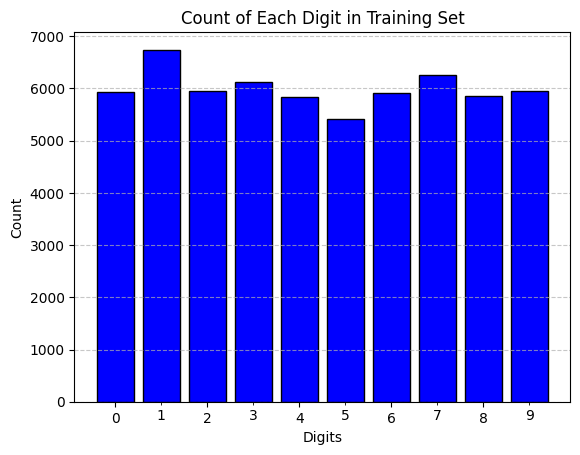

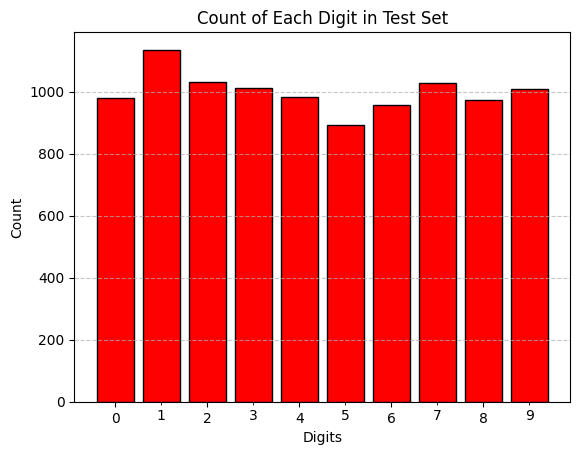

In [2]:
# Load the MNIST dataset, which is a large database of handwritten digits.
# The function returns two tuples: one for training data and one for testing data.
# Recalling, a Tuple is a collection of objects that are ordered and immutable.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# First we convert the data to float32, which helps with numerical stability. A float32 provides sufficient precision, while also being memory efficient.
# Most modern CPU's and GPU's are optimized for float32 operations, making computations faster.
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Then we convert the training data to have a channel dimension, which is required for CNNs.
X_train = X_train[..., tf.newaxis] # Add the channel dimension
X_test = X_test[..., tf.newaxis] # Add the channel dimension
print(f"New shape for X_train for CNN's: {X_train.shape}")
print(f"New shape for X_test for CNN's: {X_test.shape}")

# Declare the types of the loaded data for clarity.
X_train: NDArray[np.float32]
Y_train: NDArray[np.uint8]
X_test: NDArray[np.float32]
Y_test: NDArray[np.uint8]

# We set the line width to a large value to avoid line breaks when printing the array.
with np.printoptions(linewidth=10000):
    # Print the shapes of the datasets to understand their dimensions.
    print("Shape of X_train:\t", X_train.shape)
    print("Shape of X_test:\t", X_test.shape)
    print("Shape of Y_train:\t", Y_train.shape)
    print("Shape of Y_test:\t", Y_test.shape)
    print(f"X_train data type: {X_train.dtype}")
    print(f"X_test data type: {X_test.dtype}")
    print(f"Y_train data type: {Y_train.dtype}")
    print(f"Y_test data type: {Y_test.dtype}")

    # Inspect a single data sample to see what it looks like.
    n: int = 567
    print(f"\nX_train data {n}-th element (a 28x28 pixel image):\n", np.squeeze(X_train[n]))
    print("\nAnd its corresponding label:\t", Y_train[n])

    # To do: For using this data in a neural network,
    # Tensorflow/Keras expects the input data to be in a 1D or 2D array format where each row represents a single sample and each column represents a feature. The general format for the input shape is: (batch_size, feature_1, feature_2, ...)
    # However, we can use the tf.keras.layers.Flatten layer as the first layer in our sequential model.
    # This layer automatically flattens the input shape without the need for manual reshaping of our data.
    # For a Dense (fully connected) network: We must flatten each 28x28 image into a single 1D array of 784 pixels. The input shape for the first layer of our model would then be (None, 784), where None represents a variable batch size.
    # For a Convolutional Neural Network (CNN): We must add a channel dimension. Since the images are grayscale, there is only one channel. We would reshape the data to (number_of_images, 28, 28, 1). The input shape for the first layer (typically a Conv2D layer) would be (28, 28, 1). The batch size is handled automatically by Keras.
    # Scaling can also be performd in the model using a tf.keras.layers.Rescaling or keras.layers.Normalization layer as the first layer in our sequential model.
    # The advantage of using these layers is that they integrate seamlessly into the model architecture, ensuring that the data is preprocessed consistently during both training and inference.
    # This approach also simplifies the code by reducing the need for separate preprocessing steps outside the model definition.
    # And, it ensures that inference data is processed in the same way as training data, which is crucial for maintaining model performance.

    # Analyze the distribution of the digits in the training set.
    # `np.unique` finds the unique digit labels and `return_counts=True` counts their occurrences.
    dataset_train_distribution: Tuple[np.ndarray, np.ndarray] = np.unique(Y_train, return_counts=True)
    digits_train: np.ndarray = dataset_train_distribution[0]
    counts_train: np.ndarray = dataset_train_distribution[1]
    
    print("\n--- Train Dataset Distribution ---")
    print("Digits:\t\t\t", digits_train)
    print("Count per digit:\t", counts_train)
    
    # Calculate basic statistics on the distribution.
    avg: float = np.mean(counts_train)
    print(f"Average sample size:\t {avg:.2f}")
    
    max_count_train: np.int64 = np.max(counts_train)
    min_count_train: np.int64 = np.min(counts_train)
    print(f"Maximum sample size:\t {max_count_train}")
    print(f"Minimum sample size:\t {min_count_train}")


    dataset_test_distribution: Tuple[np.ndarray, np.ndarray] = np.unique(Y_test, return_counts=True)
    digits_test: np.ndarray = dataset_test_distribution[0]
    counts_test: np.ndarray = dataset_test_distribution[1]
    
    print("\n--- Test Dataset Distribution ---")
    print("Digits:\t\t\t", digits_test)
    print("Count per digit:\t", counts_test)
    
    # Calculate basic statistics on the distribution.
    avg: float = np.mean(counts_test)
    print(f"Average sample size:\t {avg:.2f}")
    
    max_count_test: np.int64 = np.max(counts_test)
    min_count_test: np.int64 = np.min(counts_test)
    print(f"Maximum sample size:\t {max_count_test}")
    print(f"Minimum sample size:\t {min_count_test}")

# Create a bar chart from the counts and digits to visualize the distribution.
plt.bar(digits_train, counts_train, color='blue', edgecolor='black')

# Set the title and labels for clarity.
plt.title('Count of Each Digit in Training Set')
plt.xlabel('Digits')
plt.ylabel('Count')

# Set x-ticks to be at the center of each bar and label them with the digit.
# Minor ticks are used here to place the labels directly under the bars.
# Ticks specify the positions on the x-axis where the labels should be placed.
# By setting ticks=digits_train, we ensure that each digit (0-9) is labeled correctly under its corresponding bar.
plt.xticks(ticks=digits_train, minor=True, labels=digits_train)

# Add a grid for better readability.
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot.
plt.show()

# And the same bar chart for the test set.

# Create a bar chart from the counts and digits to visualize the distribution.
plt.bar(digits_test, counts_test, color='red', edgecolor='black')

# Set the title and labels for clarity.
plt.title('Count of Each Digit in Test Set')
plt.xlabel('Digits')
plt.ylabel('Count')

# Set x-ticks to be at the center of each bar and label them with the digit.
plt.xticks(ticks=digits_test, minor=True, labels=digits_test)

# Add a grid for better readability.
plt.grid(axis='y', linestyle='--', alpha=0.7)


## Dataset Analysis

The content and size of the training and testing datasets align with the description on the Kaggle MNIST dataset page, Hojjat, F. (2017). MNIST: The Most Famous Dataset in the World. Kaggle. Retrieved August 28, 2025, from https://www.kaggle.com/datasets/hojjatk/mnist-dataset. The plot of digit distribution shows a fairly homogeneous representation across all classes (digits 0 through 9). While the digit '1' is slightly oversampled and the digit '5' is slightly undersampled, the class imbalance is not significant enough to warrant further action for this assessment.

In a scenario where the distribution were to be significantly imbalanced and we needed to make it more homogeneous, we would use a technique called **resampling**. Resampling involves adjusting the distribution of the training data to be more balanced. There are two primary types:

- **Oversampling** involves duplicating samples from the underrepresented classes to increase their frequency.

- **Undersampling** involves removing samples from the overrepresented classes to reduce their frequency.

### Define the training loop

The 'run_experiment' function is our main pipeline for training a neural network.
It encapsulates all the necessary steps: callking the model creation function, setting default hyperparameters,
configuring callbacks for logging and monitoring, and finally training the model and return a History object for analysis.
This makes our code highly modular and reusable, allowing us to easily run different
experiments by simply changing the input parameters.

In [3]:
# The 'run_experiment' function is our main pipeline for training a neural network.
# It encapsulates all the necessary steps: creating the model, setting hyperparameters,
# configuring callbacks for logging and monitoring, and finally training the model.
# This makes our code highly modular and reusable, allowing us to easily run different
# experiments by simply changing the input parameters.

def run_experiment(
    model_creation_func: Callable[[], Model],
    hyperparameters: dict[str, int | float | str],
    parent_folder: str,
    X_train: np.ndarray | tf.Tensor,
    Y_train: np.ndarray | tf.Tensor
) -> History:
    """
    Runs a full training experiment for a given model architecture and hyperparameter set.

    Args:
        model_creation_func: A callable (function) that builds and returns a compiled Keras Model.
        hyperparameters: Dictionary containing experiment settings (learning_rate, batch_size, optimiser, epochs, etc).
        parent_folder: Path to the directory where models and results will be saved.
        X_train: Training input data (features) as a NumPy array or TensorFlow tensor.
        Y_train: Training labels (targets) as a NumPy array or TensorFlow tensor.

    Returns:
        History: A Keras History object with details of the training process.
    """

    # Create the model by calling the function provided
    model: Model = model_creation_func()

    # Set some default hyperparameter values (these will be used if not specified in the dictionary)
    default_lr: float = 0.001
    default_optimiser: str = "adam"
    default_batch_size: int = 64
    default_epochs: int = 10

    # Give the model a name if it doesn’t have one already
    if model.name is None or model.name == "":
        model.name = model_creation_func.__name__

    # Many models begin with a "normalisation" layer.
    # Here we adapt (fit) that layer to the training data so it knows the data’s mean and variance.
    print("\nAdapting the normalisation layer...")
    model.layers[0].adapt(X_train)  # type: ignore[attr-defined]
    print("Adaptation complete.\n")

    # Display a summary of what is about to happen
    print(f"\n--- Starting Experiment: {model.name} ---")
    print("\n--- Model Architecture ---")
    model.summary()
    print("\n--- Hyperparameters ---")
    for key, value in hyperparameters.items():
        print(f"{key:<20}: {value}")

    # Generate a unique run name so we can distinguish between different experiments.
    run_name: str = (
        f"{model.name}-lr_{hyperparameters.get('learning_rate', default_lr)}"
        f"-bs_{hyperparameters.get('batch_size', default_batch_size)}-"
        f"{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    )

    # Start a new run in Weights & Biases (wandb) for logging metrics and results.
    run: Any = wandb.init(
        project="CSE5ML-Assessment2",
        name=run_name,
        config=hyperparameters,
    )

    # This callback sends training metrics (loss, accuracy, etc.) to wandb in real time.
    wandb_metrics_logger: Callback = WandbMetricsLogger()

    # Choose the optimiser and learning rate based on the hyperparameters provided.
    optimiser_name: str = hyperparameters.get("optimiser", default_optimiser).lower()  # type: ignore[union-attr]
    learning_rate: float = float(hyperparameters.get("learning_rate", default_lr))

    if optimiser_name == "adam":
        optimiser: Adam | SGD | str = Adam(learning_rate=learning_rate)
    elif optimiser_name == "sgd":
        optimiser = SGD(learning_rate=learning_rate)
    elif optimiser_name == 'adamw': 
        optimiser = AdamW(learning_rate=learning_rate)
    elif optimiser_name == 'rmsprop': 
        optimiser = RMSprop(learning_rate=learning_rate)
    else:
            # It's good practice to have a fallback in case of a typo
            print(f"Warning: Unknown optimiser '{optimiser_name}'. Defaulting to Adam.")
            optimiser = Adam(learning_rate=learning_rate)

    # Create a folder to save this model’s results on disk.
    model_specific_folder: str = os.path.join(parent_folder, run_name)
    os.makedirs(model_specific_folder, exist_ok=True)

    # Define a filename pattern for saving the best models during training.
    filepath: str = os.path.join(
        model_specific_folder,
        "best_model_epoch-{epoch:02d}_val_acc-{val_accuracy:.4f}.keras"
    )

    # This callback saves the best model (on the local hard drive).
    checkpoint: ModelCheckpoint = ModelCheckpoint(
        filepath=filepath,
        monitor="val_accuracy",   # we monitor validation accuracy
        mode="max",               # we want the maximum value
        save_best_only=True,      # only save when performance improves
        verbose=1,
    )

    # This callback saves the best model (to wandb’s cloud storage).
    wandb_checkpoint: WandbModelCheckpoint = WandbModelCheckpoint(
        filepath=f"wandb_models/{run_name}/best_model.keras",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1,
    )

    # This callback stops training early if validation accuracy does not improve for a while.
    early_stopping: EarlyStopping = EarlyStopping(
        monitor="val_accuracy",
        patience=10,              # number of epochs to wait
        restore_best_weights=True # restore the best model when stopping
    )

    # Now we compile the model, telling it what optimiser, loss function, and metrics to use.
    model.compile(
        optimizer=optimiser,
        loss=hyperparameters.get("loss_function", "sparse_categorical_crossentropy"),  # type: ignore[arg-type]
        metrics=["accuracy"],
    )

    # Train the model on the provided data.
    # We use 10% of the training set as a validation set.
    history: History = model.fit(
        X_train,
        Y_train,
        epochs=int(hyperparameters.get("epochs", default_epochs)),
        batch_size=int(hyperparameters.get("batch_size", default_batch_size)),
        validation_split=0.1,
        callbacks=[checkpoint, wandb_metrics_logger, wandb_checkpoint, early_stopping],
        verbose=1,
    )

    # Save the training history (loss/accuracy curves) to disk for later analysis.
    history.hyperparameters = hyperparameters  # type: ignore[attr-defined]
    history_filepath: str = os.path.join(model_specific_folder, "training_history.pkl")
    with open(history_filepath, "wb") as f:
        pickle.dump(history.history, f)
    print(f"\nTraining history saved to: {history_filepath}")

    # Summarise peak performance at the end of training.
    val_accuracies: list[float] = history.history["val_accuracy"]
    best_validation_accuracy: float = max(val_accuracies)
    best_epoch: int = val_accuracies.index(best_validation_accuracy) + 1
    associated_train_acc: float = history.history["accuracy"][best_epoch - 1]

    print("\n--- Peak Performance Summary ---")
    print(f"{'Best validation accuracy:':<35} {best_validation_accuracy:.4f}")
    print(f"{'Associated training accuracy:':<35} {associated_train_acc:.4f}")
    print(f"{'Occurred at epoch:':<35} {best_epoch}")

    # Close the wandb run so it is properly logged.
    run.finish()

    return history

## Part 1, Task 1: Creating a simple Multilayer Perceptron (MLP) neural network

The code below defines our base model.

To experiment with different architectures or tune its hyperparameters, we simply copy this entire cell and make our changes.

We need to make sure to give each new model a unique name. This ensures that when the ModelCheckpoint callback saves the best-performing version during training, the filename will be clear and identifiable.

In [4]:
# --- Set Seeds for Reproducibility ---

# This sets the global random seed for all TensorFlow operations.
# It ensures that things like model weight initialisation are the same every time.
# `tf.random.set_seed()` is the modern way to do this in TensorFlow 2.
tf.random.set_seed(1)

# This sets the random seed for all NumPy operations.
# This is important if we are creating our data using NumPy or using any
# NumPy functions that involve randomness.
np.random.seed(23)

In [5]:
# **Task 1**

# Build a neural network without convolutional layers to do the classification task (hint: you will need the use of dense layers). 
# Then you can change the model structure (i.e. number of dense layers, number of neurons in dense layers or activation functions) to be able to improve network performance.

def create_mlp_model_base() -> Sequential:
    """
    Defines and returns the (base) MLP model architecture.
    """
    # Note: we can change the model architecture here. However, it is more prudent to save the model parameters first, and then change it. 
    model = Sequential([
        # We use the implicit input_shape here for a cleaner look.
        Input(shape=(28, 28, 1)),
        Normalization(),
        Flatten(),
        Dense(units=32, activation='relu'), # Relu is the goto activation function. We could also use LeakyRelu, tanh, sigmoid, etc.
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name = "Base_MLP_Model")
    return model

## Creating variations of the MLP base model

In [6]:
def create_mlp_model_2() -> Sequential:
    """
    Defines and returns the (base) MLP model architecture.
    """
    model = Sequential([
        # We use the implicit input_shape here for a cleaner look.
        Input(shape=(28, 28, 1)),
        Normalization(),
        Flatten(),
        Dense(units=64, activation='relu'), # Relu is the goto activation function. We could also use LeakyRelu, tanh, sigmoid, etc.
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name = "Base_MLP_Model_2")
    return model

In [7]:
# This is our first "base" model we created. Repeated here, because it yielded very good accuracies on both validate and test data, as well as loss. 
def create_mlp_model_3() -> Sequential:
    """
    Defines and returns the (base) MLP model architecture.
    """
    model = Sequential([
        # We use the implicit input_shape here for a cleaner look.
        Input(shape=(28, 28, 1)),
        Normalization(),
        Flatten(),
        Dense(units=128, activation='relu'), # Relu is the goto activation function. We could also use LeakyRelu, 
        Dense(units=256, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name = "Base_MLP_Model_3")
    return model

In [8]:
def create_mlp_model_wide() -> Sequential:
    """
    Defines and returns the (base) MLP model architecture.
    """
    # Note: we can change the model architecture here. However, it is more prudent to save the model parameters first, and then change it. 
    model = Sequential([
        # We use the implicit input_shape here for a cleaner look.
        Input(shape=(28, 28, 1)),
        Normalization(),
        Flatten(),
        Dense(units=512, activation='relu'),
        Dense(units=1024, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name = "Wide_MLP_Model")
    return model

In [9]:
def create_mlp_model_deep() -> Sequential:
    """
    Defines and returns the (base) MLP model architecture.
    """
    # Note: we can change the model architecture here. However, it is more prudent to save the model parameters first, and then change it. 
    model = Sequential([
        # We use the implicit input_shape here for a cleaner look.
        Input(shape=(28, 28, 1)),
        Normalization(),
        Flatten(),
        Dense(units=128, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name="Deep_MLP_Model")
    return model

In [10]:
# All MLP models:
mlp_model_functions: List[Callable] = [
    create_mlp_model_base,
    create_mlp_model_2,
    create_mlp_model_3,
    create_mlp_model_wide,
    create_mlp_model_deep,
]

# # # Only a single model:
# # mlp_model_functions = [
# #     create_mlp_model_3,
# # ]

### Define sets of hyperparameters for the MLP models

The cell below allow us to set a plethora of hyperparameters, such as the learning rate, batch_size, but also the optimiser and the number of epochs the training loop is run for. 

In [11]:
# --- Define Hyperparameter Sets ---
# Part 1 Task 3 only requires one experiment with an MLP, so we will just define one hyperparameter set for the MLP here.
mlp_epochs: int = 100
mlp_batch_size: int = 64
# Experiment 1: Our baseline run
# We choose SGD as our optimiser because it is expected that the loss landscape of our simple MLP model is largely convex. 
mlp_exp_1_config: Dict[str, Union[str, float, int]] = {
    "optimiser": "adamw",
    "learning_rate": 0.001, # The optimal, or at least a satisfactory LR will have to be identified by experimenting. We start with LR = 0.01. This does not lead to convergence of Loss and Accuracy. So LR=0.001 is used. 
    "epochs": mlp_epochs,
    "batch_size": mlp_batch_size
}

# Experiment 2: Same as the MLP_Baseline but with a higher learning rate
mlp_exp_2_config = {
    "optimiser": "adamw",
    "learning_rate": 0.01,
    "epochs": mlp_epochs,
    "batch_size": mlp_batch_size,
}

# Experiment 3: Same as the MLP_Baseline but with a different optimizer (SGD)
mlp_exp_3_config = {
    "optimiser": "SGD",
    "learning_rate": 0.001,
    "epochs": mlp_epochs,
    "batch_size": mlp_batch_size,
}

# Experiment 4: Same as the MLP_Baseline but with a different optimizer (SGD) and a higher learning rate
mlp_exp_4_config = {
    "optimiser": "SGD",
    "learning_rate": 0.01,
    "epochs": mlp_epochs,
    "batch_size": mlp_batch_size,
}

mlp_config: List[Dict[str, Union[str, float, int]]] = [mlp_exp_1_config, mlp_exp_2_config, mlp_exp_3_config, mlp_exp_4_config]

## Training the MLP models

In [12]:
run_mlp_experiments: bool = True # A simple flag to control whether we run the MLP experiments or not. 

all_exp_params: bool = True # A flag to control whether we use the entire set of hyperparameters to train with, or just a single set. 

# --- Run the full list of experiments ---
if run_mlp_experiments:
    mlp_histories: List[History] = []
    for mlp_model_function in mlp_model_functions:
        if not all_exp_params:
            mlp_history: History = run_experiment(
                model_creation_func=mlp_model_function, 
                hyperparameters=mlp_exp_1_config,  # If we do not set the all experiment parameters to True, then we only need the 1 config file. 
                parent_folder='MLP_Models',
                X_train=X_train,
                Y_train=Y_train,
            )
        else:
            for config in mlp_config:
                mlp_history: History = run_experiment(
                    model_creation_func=mlp_model_function, 
                    hyperparameters=config, 
                    parent_folder='MLP_Models',
                    X_train=X_train,
                    Y_train=Y_train,
                )

        mlp_histories.append(mlp_history)

# # --- To run the second experiment, we just call it again with a different config (hyper parameter set) :-)
# --- We first  test different model architectures before running more experiments with different hyperparameters (Part 1 Task 1 & 2). ---
# --- THen we test the best performing model of Part 1 Task 1& 2 with different hyperparameters. ---


Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_MLP_Model ---

--- Model Architecture ---


Model: "Base_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,645 (115.80 KB)

 Trainable params: 29,642 (115.79 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


wandb: Currently logged in as: tim-vos-nl (tim-vos-nl-mine) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/100
820/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7956 - loss: 0.6571
Epoch 1: val_accuracy improved from None to 0.95367, saving model to MLP_Models\Base_MLP_Model-lr_0.001-bs_64-20250917-074814\best_model_epoch-01_val_acc-0.9537.keras

Epoch 1: val_accuracy improved from None to 0.95367, saving model to wandb_models/Base_MLP_Model-lr_0.001-bs_64-20250917-074814/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8899 - loss: 0.3595 - val_accuracy: 0.9537 - val_loss: 0.1532
Epoch 2/100
814/844 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9472 - loss: 0.1760
Epoch 2: val_accuracy improved from 0.95367 to 0.96533, saving model to MLP_Models\Base_MLP_Model-lr_0.001-bs_64-20250917-074814\best_model_epoch-02_val_acc-0.9653.keras

Epoch 2: val_accuracy improved from 0.95367 to 0.96533, saving model to wandb_models/Base_MLP_Model-lr_0.001-bs_64-20250917-074814/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9513 - loss: 0.1610 - 

epoch/accuracy,▁▅▆▇▇▇▇█████████
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▇▇▇█▇▇▆▇▇▇▇█▇█
epoch/val_loss,█▃▂▁▂▁▂▄▄▄▄▄▅▄▅▇
epoch/accuracy,0.98841
epoch/epoch,15
epoch/learning_rate,0.001
epoch/loss,0.03577
epoch/val_accuracy,0.97133



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_MLP_Model ---

--- Model Architecture ---


Model: "Base_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,645 (115.80 KB)

 Trainable params: 29,642 (115.79 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.01
epochs              : 100
batch_size          : 64


Epoch 1/100
812/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8248 - loss: 0.5539
Epoch 1: val_accuracy improved from None to 0.93300, saving model to MLP_Models\Base_MLP_Model-lr_0.01-bs_64-20250917-074912\best_model_epoch-01_val_acc-0.9330.keras

Epoch 1: val_accuracy improved from None to 0.93300, saving model to wandb_models/Base_MLP_Model-lr_0.01-bs_64-20250917-074912/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8875 - loss: 0.3720 - val_accuracy: 0.9330 - val_loss: 0.2340
Epoch 2/100
832/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9222 - loss: 0.2680
Epoch 2: val_accuracy improved from 0.93300 to 0.95117, saving model to MLP_Models\Base_MLP_Model-lr_0.01-bs_64-20250917-074912\best_model_epoch-02_val_acc-0.9512.keras

Epoch 2: val_accuracy improved from 0.93300 to 0.95117, saving model to wandb_models/Base_MLP_Model-lr_0.01-bs_64-20250917-074912/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9254 - loss: 0.2600 - val_

epoch/accuracy,▁▅▆▆▆▇▇▇▇▇▇█▇▇████████
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▄▆▇▆▆█▇▅▆██▇▆▇▆▆█▇▆▄
epoch/val_loss,█▂▄▄▃▃▃▁▂▄▂▁▂▂▃▃▄▄▂▃▃▆
epoch/accuracy,0.95696
epoch/epoch,21
epoch/learning_rate,0.01
epoch/loss,0.16722
epoch/val_accuracy,0.9465



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_MLP_Model ---

--- Model Architecture ---


Model: "Base_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,645 (115.80 KB)

 Trainable params: 29,642 (115.79 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
813/844 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1944 - loss: 2.1785
Epoch 1: val_accuracy improved from None to 0.64217, saving model to MLP_Models\Base_MLP_Model-lr_0.001-bs_64-20250917-075025\best_model_epoch-01_val_acc-0.6422.keras

Epoch 1: val_accuracy improved from None to 0.64217, saving model to wandb_models/Base_MLP_Model-lr_0.001-bs_64-20250917-075025/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3303 - loss: 1.9432 - val_accuracy: 0.6422 - val_loss: 1.4364
Epoch 2/100
813/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6791 - loss: 1.2516
Epoch 2: val_accuracy improved from 0.64217 to 0.83050, saving model to MLP_Models\Base_MLP_Model-lr_0.001-bs_64-20250917-075025\best_model_epoch-02_val_acc-0.8305.keras

Epoch 2: val_accuracy improved from 0.64217 to 0.83050, saving model to wandb_models/Base_MLP_Model-lr_0.001-bs_64-20250917-075025/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7291 - loss: 1.0544 - 

epoch/accuracy,▁▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████████
epoch/val_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.96633
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.11485
epoch/val_accuracy,0.968



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_MLP_Model ---

--- Model Architecture ---


Model: "Base_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,645 (115.80 KB)

 Trainable params: 29,642 (115.79 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.01
epochs              : 100
batch_size          : 64


Epoch 1/100
837/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5493 - loss: 1.3422
Epoch 1: val_accuracy improved from None to 0.91167, saving model to MLP_Models\Base_MLP_Model-lr_0.01-bs_64-20250917-075530\best_model_epoch-01_val_acc-0.9117.keras

Epoch 1: val_accuracy improved from None to 0.91167, saving model to wandb_models/Base_MLP_Model-lr_0.01-bs_64-20250917-075530/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7454 - loss: 0.8071 - val_accuracy: 0.9117 - val_loss: 0.2998
Epoch 2/100
837/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8998 - loss: 0.3348
Epoch 2: val_accuracy improved from 0.91167 to 0.93417, saving model to MLP_Models\Base_MLP_Model-lr_0.01-bs_64-20250917-075530\best_model_epoch-02_val_acc-0.9342.keras

Epoch 2: val_accuracy improved from 0.91167 to 0.93417, saving model to wandb_models/Base_MLP_Model-lr_0.01-bs_64-20250917-075530/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9063 - loss: 0.3129 - val_

epoch/accuracy,▁▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▆▆▆▇▇▇▇▇███████████████████████████
epoch/val_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.98957
epoch/epoch,37
epoch/learning_rate,0.01
epoch/loss,0.03971
epoch/val_accuracy,0.97133



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_MLP_Model_2 ---

--- Model Architecture ---


Model: "Base_MLP_Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,469 (263.55 KB)

 Trainable params: 67,466 (263.54 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
836/844 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8462 - loss: 0.4809
Epoch 1: val_accuracy improved from None to 0.96917, saving model to MLP_Models\Base_MLP_Model_2-lr_0.001-bs_64-20250917-075738\best_model_epoch-01_val_acc-0.9692.keras

Epoch 1: val_accuracy improved from None to 0.96917, saving model to wandb_models/Base_MLP_Model_2-lr_0.001-bs_64-20250917-075738/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9151 - loss: 0.2723 - val_accuracy: 0.9692 - val_loss: 0.1087
Epoch 2/100
831/844 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9569 - loss: 0.1349
Epoch 2: val_accuracy improved from 0.96917 to 0.97433, saving model to MLP_Models\Base_MLP_Model_2-lr_0.001-bs_64-20250917-075738\best_model_epoch-02_val_acc-0.9743.keras

Epoch 2: val_accuracy improved from 0.96917 to 0.97433, saving model to wandb_models/Base_MLP_Model_2-lr_0.001-bs_64-20250917-075738/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9610 - loss: 0

epoch/accuracy,▁▅▆▇▇▇▇▇▇██████████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▆▆▆▅▇▅█▄▆█▆▇▃▆▇▅▆
epoch/val_loss,▄▁▁▂▂▃▂▄▃▄▄▃▅▅█▆▆▆▅
epoch/accuracy,0.99361
epoch/epoch,18
epoch/learning_rate,0.001
epoch/loss,0.01922
epoch/val_accuracy,0.97617



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_MLP_Model_2 ---

--- Model Architecture ---


Model: "Base_MLP_Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_5 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,469 (263.55 KB)

 Trainable params: 67,466 (263.54 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.01
epochs              : 100
batch_size          : 64


Epoch 1/100
818/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8496 - loss: 0.4844
Epoch 1: val_accuracy improved from None to 0.94600, saving model to MLP_Models\Base_MLP_Model_2-lr_0.01-bs_64-20250917-075846\best_model_epoch-01_val_acc-0.9460.keras

Epoch 1: val_accuracy improved from None to 0.94600, saving model to wandb_models/Base_MLP_Model_2-lr_0.01-bs_64-20250917-075846/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9032 - loss: 0.3336 - val_accuracy: 0.9460 - val_loss: 0.1902
Epoch 2/100
829/844 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9357 - loss: 0.2398
Epoch 2: val_accuracy improved from 0.94600 to 0.94833, saving model to MLP_Models\Base_MLP_Model_2-lr_0.01-bs_64-20250917-075846\best_model_epoch-02_val_acc-0.9483.keras

Epoch 2: val_accuracy improved from 0.94600 to 0.94833, saving model to wandb_models/Base_MLP_Model_2-lr_0.01-bs_64-20250917-075846/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9389 - loss: 0.229

epoch/accuracy,▁▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁
epoch/val_accuracy,▁▂▄▄▅▆▆▇▇▆▆▇▇▆▇▆█▇█▂▇▅█▇▇▆▆
epoch/val_loss,▄▄▄▂▃▂▁▁▂▃▃▃▂▂▂▃▂▃▂█▃▅▂▂▃▃▄
epoch/accuracy,0.97263
epoch/epoch,26
epoch/learning_rate,0.01
epoch/loss,0.11571
epoch/val_accuracy,0.96317



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_MLP_Model_2 ---

--- Model Architecture ---


Model: "Base_MLP_Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_6 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,469 (263.55 KB)

 Trainable params: 67,466 (263.54 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
824/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3088 - loss: 2.0911
Epoch 1: val_accuracy improved from None to 0.77433, saving model to MLP_Models\Base_MLP_Model_2-lr_0.001-bs_64-20250917-080017\best_model_epoch-01_val_acc-0.7743.keras

Epoch 1: val_accuracy improved from None to 0.77433, saving model to wandb_models/Base_MLP_Model_2-lr_0.001-bs_64-20250917-080017/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4971 - loss: 1.7510 - val_accuracy: 0.7743 - val_loss: 1.0537
Epoch 2/100
810/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7772 - loss: 0.9277
Epoch 2: val_accuracy improved from 0.77433 to 0.87000, saving model to MLP_Models\Base_MLP_Model_2-lr_0.001-bs_64-20250917-080017\best_model_epoch-02_val_acc-0.8700.keras

Epoch 2: val_accuracy improved from 0.77433 to 0.87000, saving model to wandb_models/Base_MLP_Model_2-lr_0.001-bs_64-20250917-080017/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8025 - loss: 0

epoch/accuracy,▁▃▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████████
epoch/epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████████████████
epoch/val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.97715
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.08065
epoch/val_accuracy,0.972



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_MLP_Model_2 ---

--- Model Architecture ---


Model: "Base_MLP_Model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_7 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,469 (263.55 KB)

 Trainable params: 67,466 (263.54 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.01
epochs              : 100
batch_size          : 64


Epoch 1/100
838/844 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6628 - loss: 1.0657
Epoch 1: val_accuracy improved from None to 0.92450, saving model to MLP_Models\Base_MLP_Model_2-lr_0.01-bs_64-20250917-080628\best_model_epoch-01_val_acc-0.9245.keras

Epoch 1: val_accuracy improved from None to 0.92450, saving model to wandb_models/Base_MLP_Model_2-lr_0.01-bs_64-20250917-080628/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8141 - loss: 0.6201 - val_accuracy: 0.9245 - val_loss: 0.2597
Epoch 2/100
818/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9150 - loss: 0.2885
Epoch 2: val_accuracy improved from 0.92450 to 0.94533, saving model to MLP_Models\Base_MLP_Model_2-lr_0.01-bs_64-20250917-080628\best_model_epoch-02_val_acc-0.9453.keras

Epoch 2: val_accuracy improved from 0.92450 to 0.94533, saving model to wandb_models/Base_MLP_Model_2-lr_0.01-bs_64-20250917-080628/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9215 - loss: 0.268

epoch/accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▆▆▇▇▇▇▇██████████████████████████████
epoch/val_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.99906
epoch/epoch,47
epoch/learning_rate,0.01
epoch/loss,0.00935
epoch/val_accuracy,0.97667



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_MLP_Model_3 ---

--- Model Architecture ---


Model: "Base_MLP_Model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_8 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,605 (588.30 KB)

 Trainable params: 150,602 (588.29 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
835/844 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8750 - loss: 0.4070
Epoch 1: val_accuracy improved from None to 0.96750, saving model to MLP_Models\Base_MLP_Model_3-lr_0.001-bs_64-20250917-081005\best_model_epoch-01_val_acc-0.9675.keras

Epoch 1: val_accuracy improved from None to 0.96750, saving model to wandb_models/Base_MLP_Model_3-lr_0.001-bs_64-20250917-081005/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9283 - loss: 0.2356 - val_accuracy: 0.9675 - val_loss: 0.1171
Epoch 2/100
841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9648 - loss: 0.1146
Epoch 2: val_accuracy improved from 0.96750 to 0.97533, saving model to MLP_Models\Base_MLP_Model_3-lr_0.001-bs_64-20250917-081005\best_model_epoch-02_val_acc-0.9753.keras

Epoch 2: val_accuracy improved from 0.96750 to 0.97533, saving model to wandb_models/Base_MLP_Model_3-lr_0.001-bs_64-20250917-081005/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9684 - los

epoch/accuracy,▁▅▆▇▇▇▇▇▇█████████████
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▇▅▄▆▇▅▇▅▇█▆▇▆▇▅▆▇▆█▆
epoch/val_loss,▇▂▁▃▅▅▅▄▃▇▅▄▅▄█▆█▇▇█▅▇
epoch/accuracy,0.99581
epoch/epoch,21
epoch/learning_rate,0.001
epoch/loss,0.01399
epoch/val_accuracy,0.97767



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_MLP_Model_3 ---

--- Model Architecture ---


Model: "Base_MLP_Model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_9 (Normalization) │ (None, 28, 28, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,605 (588.30 KB)

 Trainable params: 150,602 (588.29 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.01
epochs              : 100
batch_size          : 64


Epoch 1/100
837/844 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8284 - loss: 0.5896
Epoch 1: val_accuracy improved from None to 0.94467, saving model to MLP_Models\Base_MLP_Model_3-lr_0.01-bs_64-20250917-081301\best_model_epoch-01_val_acc-0.9447.keras

Epoch 1: val_accuracy improved from None to 0.94467, saving model to wandb_models/Base_MLP_Model_3-lr_0.01-bs_64-20250917-081301/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8968 - loss: 0.3572 - val_accuracy: 0.9447 - val_loss: 0.2020
Epoch 2/100
840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9343 - loss: 0.2435
Epoch 2: val_accuracy improved from 0.94467 to 0.95150, saving model to MLP_Models\Base_MLP_Model_3-lr_0.01-bs_64-20250917-081301\best_model_epoch-02_val_acc-0.9515.keras

Epoch 2: val_accuracy improved from 0.94467 to 0.95150, saving model to wandb_models/Base_MLP_Model_3-lr_0.01-bs_64-20250917-081301/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9350 - loss: 0.241

epoch/accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▂▁▁▁▁
epoch/val_accuracy,▁▃▃▆▅▆▇▆▇▇▅▆▇▅▆▇▆█▇▆▆▇▇▇▇█▆▅▇▅▇▆▆▇█▇
epoch/val_loss,█▆▅▂▅▃▁▃▁▁▄▅▂▆▂▃▂▁▃▄▃▁▂▃▃▃▆█▄▆▄▅▄▄▃▅
epoch/accuracy,0.97352
epoch/epoch,35
epoch/learning_rate,0.01
epoch/loss,0.10868
epoch/val_accuracy,0.96483



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_MLP_Model_3 ---

--- Model Architecture ---


Model: "Base_MLP_Model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_10                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,605 (588.30 KB)

 Trainable params: 150,602 (588.29 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
833/844 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3168 - loss: 2.0437
Epoch 1: val_accuracy improved from None to 0.79883, saving model to MLP_Models\Base_MLP_Model_3-lr_0.001-bs_64-20250917-081550\best_model_epoch-01_val_acc-0.7988.keras

Epoch 1: val_accuracy improved from None to 0.79883, saving model to wandb_models/Base_MLP_Model_3-lr_0.001-bs_64-20250917-081550/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5145 - loss: 1.6499 - val_accuracy: 0.7988 - val_loss: 0.9268
Epoch 2/100
829/844 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7958 - loss: 0.8401
Epoch 2: val_accuracy improved from 0.79883 to 0.87717, saving model to MLP_Models\Base_MLP_Model_3-lr_0.001-bs_64-20250917-081550\best_model_epoch-02_val_acc-0.8772.keras

Epoch 2: val_accuracy improved from 0.79883 to 0.87717, saving model to wandb_models/Base_MLP_Model_3-lr_0.001-bs_64-20250917-081550/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8162 - loss: 0

epoch/accuracy,▁▆▇▇▇▇▇▇▇███████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▆▆▆▇▇▇▇▇▇▇▇▇███████████████████████████
epoch/val_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.9808
epoch/epoch,92
epoch/learning_rate,0.001
epoch/loss,0.0674
epoch/val_accuracy,0.97567



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_MLP_Model_3 ---

--- Model Architecture ---


Model: "Base_MLP_Model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_11                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,605 (588.30 KB)

 Trainable params: 150,602 (588.29 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.01
epochs              : 100
batch_size          : 64


Epoch 1/100
821/844 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7134 - loss: 0.9693
Epoch 1: val_accuracy improved from None to 0.93433, saving model to MLP_Models\Base_MLP_Model_3-lr_0.01-bs_64-20250917-082144\best_model_epoch-01_val_acc-0.9343.keras

Epoch 1: val_accuracy improved from None to 0.93433, saving model to wandb_models/Base_MLP_Model_3-lr_0.01-bs_64-20250917-082144/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8415 - loss: 0.5516 - val_accuracy: 0.9343 - val_loss: 0.2248
Epoch 2/100
842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9272 - loss: 0.2547
Epoch 2: val_accuracy improved from 0.93433 to 0.95183, saving model to MLP_Models\Base_MLP_Model_3-lr_0.01-bs_64-20250917-082144\best_model_epoch-02_val_acc-0.9518.keras

Epoch 2: val_accuracy improved from 0.93433 to 0.95183, saving model to wandb_models/Base_MLP_Model_3-lr_0.01-bs_64-20250917-082144/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9297 - loss: 0.238

epoch/accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▅▆▇▇▇▇▇▇▇▇▇▇█▇███████████████████████
epoch/val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
epoch/accuracy,0.99996
epoch/epoch,54
epoch/learning_rate,0.01
epoch/loss,0.0031
epoch/val_accuracy,0.97867



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Wide_MLP_Model ---

--- Model Architecture ---


Model: "Wide_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_12                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,192,205 (4.55 MB)

 Trainable params: 1,192,202 (4.55 MB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8934 - loss: 0.3411
Epoch 1: val_accuracy improved from None to 0.96817, saving model to MLP_Models\Wide_MLP_Model-lr_0.001-bs_64-20250917-082538\best_model_epoch-01_val_acc-0.9682.keras

Epoch 1: val_accuracy improved from None to 0.96817, saving model to wandb_models/Wide_MLP_Model-lr_0.001-bs_64-20250917-082538/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9358 - loss: 0.2072 - val_accuracy: 0.9682 - val_loss: 0.1047
Epoch 2/100
841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9677 - loss: 0.1062
Epoch 2: val_accuracy improved from 0.96817 to 0.97350, saving model to MLP_Models\Wide_MLP_Model-lr_0.001-bs_64-20250917-082538\best_model_epoch-02_val_acc-0.9735.keras

Epoch 2: val_accuracy improved from 0.96817 to 0.97350, saving model to wandb_models/Wide_MLP_Model-lr_0.001-bs_64-20250917-082538/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9721 - loss: 0.0

epoch/accuracy,▁▅▆▆▇▇▇▇▇▇█████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▃▄▅▆▅▆▅▆▄▇▆▆▆▇▆▇▇▆▆▇▇▆█▇▆▇▇▇▇▇▇▇▇
epoch/val_loss,▃▁▂▃▂▁▂▃▃▂▆▁▃▅▅▃▇▄▃▂▄▃▇▇▄▄▆▃▅▇▇██▅█
epoch/accuracy,0.99659
epoch/epoch,34
epoch/learning_rate,0.001
epoch/loss,0.01373
epoch/val_accuracy,0.9815



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Wide_MLP_Model ---

--- Model Architecture ---


Model: "Wide_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_13                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,192,205 (4.55 MB)

 Trainable params: 1,192,202 (4.55 MB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.01
epochs              : 100
batch_size          : 64


Epoch 1/100
843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8103 - loss: 0.9786
Epoch 1: val_accuracy improved from None to 0.93100, saving model to MLP_Models\Wide_MLP_Model-lr_0.01-bs_64-20250917-083319\best_model_epoch-01_val_acc-0.9310.keras

Epoch 1: val_accuracy improved from None to 0.93100, saving model to wandb_models/Wide_MLP_Model-lr_0.01-bs_64-20250917-083319/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8782 - loss: 0.4879 - val_accuracy: 0.9310 - val_loss: 0.2454
Epoch 2/100
841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9161 - loss: 0.3228
Epoch 2: val_accuracy improved from 0.93100 to 0.94050, saving model to MLP_Models\Wide_MLP_Model-lr_0.01-bs_64-20250917-083319\best_model_epoch-02_val_acc-0.9405.keras

Epoch 2: val_accuracy improved from 0.93100 to 0.94050, saving model to wandb_models/Wide_MLP_Model-lr_0.01-bs_64-20250917-083319/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9188 - loss: 0.3072 

epoch/accuracy,▁▅▆▆▆▇▇▇▇▇▇██▇████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁
epoch/val_accuracy,▁▄▅▆▅▇▇█▄▅▅▆█▅▇▅▇▇
epoch/val_loss,█▅▆▅▄▃▃▁▇▃▅▆▂▆▄█▃▃
epoch/accuracy,0.95313
epoch/epoch,17
epoch/learning_rate,0.01
epoch/loss,0.1864
epoch/val_accuracy,0.95467



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Wide_MLP_Model ---

--- Model Architecture ---


Model: "Wide_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_14                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,192,205 (4.55 MB)

 Trainable params: 1,192,202 (4.55 MB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5317 - loss: 1.6300
Epoch 1: val_accuracy improved from None to 0.88433, saving model to MLP_Models\Wide_MLP_Model-lr_0.001-bs_64-20250917-083729\best_model_epoch-01_val_acc-0.8843.keras

Epoch 1: val_accuracy improved from None to 0.88433, saving model to wandb_models/Wide_MLP_Model-lr_0.001-bs_64-20250917-083729/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.7052 - loss: 1.1885 - val_accuracy: 0.8843 - val_loss: 0.5726
Epoch 2/100
841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8583 - loss: 0.5722
Epoch 2: val_accuracy improved from 0.88433 to 0.91133, saving model to MLP_Models\Wide_MLP_Model-lr_0.001-bs_64-20250917-083729\best_model_epoch-02_val_acc-0.9113.keras

Epoch 2: val_accuracy improved from 0.88433 to 0.91133, saving model to wandb_models/Wide_MLP_Model-lr_0.001-bs_64-20250917-083729/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8681 - loss: 0.5191

epoch/accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████████████
epoch/val_loss,█▇▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.99141
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.03993
epoch/val_accuracy,0.98067



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Wide_MLP_Model ---

--- Model Architecture ---


Model: "Wide_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_15                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,192,205 (4.55 MB)

 Trainable params: 1,192,202 (4.55 MB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.01
epochs              : 100
batch_size          : 64


Epoch 1/100
837/844 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8023 - loss: 0.7221
Epoch 1: val_accuracy improved from None to 0.94167, saving model to MLP_Models\Wide_MLP_Model-lr_0.01-bs_64-20250917-085200\best_model_epoch-01_val_acc-0.9417.keras

Epoch 1: val_accuracy improved from None to 0.94167, saving model to wandb_models/Wide_MLP_Model-lr_0.01-bs_64-20250917-085200/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8829 - loss: 0.4222 - val_accuracy: 0.9417 - val_loss: 0.1938
Epoch 2/100
840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9373 - loss: 0.2162
Epoch 2: val_accuracy improved from 0.94167 to 0.95983, saving model to MLP_Models\Wide_MLP_Model-lr_0.01-bs_64-20250917-085200\best_model_epoch-02_val_acc-0.9598.keras

Epoch 2: val_accuracy improved from 0.94167 to 0.95983, saving model to wandb_models/Wide_MLP_Model-lr_0.01-bs_64-20250917-085200/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9409 - loss: 0.2007 - val

epoch/accuracy,▁▄▅▆▇▇▇▇▇▇██████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▆▆▇▇▇▇███████████████████████████████
epoch/val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.99998
epoch/epoch,48
epoch/learning_rate,0.01
epoch/loss,0.0019
epoch/val_accuracy,0.98217



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Deep_MLP_Model ---

--- Model Architecture ---


Model: "Deep_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_16                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,741 (1.33 MB)

 Trainable params: 349,738 (1.33 MB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8360 - loss: 0.5058
Epoch 1: val_accuracy improved from None to 0.96033, saving model to MLP_Models\Deep_MLP_Model-lr_0.001-bs_64-20250917-085915\best_model_epoch-01_val_acc-0.9603.keras

Epoch 1: val_accuracy improved from None to 0.96033, saving model to wandb_models/Deep_MLP_Model-lr_0.001-bs_64-20250917-085915/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9132 - loss: 0.2817 - val_accuracy: 0.9603 - val_loss: 0.1355
Epoch 2/100
838/844 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9609 - loss: 0.1389
Epoch 2: val_accuracy improved from 0.96033 to 0.97350, saving model to MLP_Models\Deep_MLP_Model-lr_0.001-bs_64-20250917-085915\best_model_epoch-02_val_acc-0.9735.keras

Epoch 2: val_accuracy improved from 0.96033 to 0.97350, saving model to wandb_models/Deep_MLP_Model-lr_0.001-bs_64-20250917-085915/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9635 - loss: 0.1268 -

epoch/accuracy,▁▅▆▆▇▇▇▇▇▇▇████████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▄▄▅▆▆▅▆▇▆▆▇▇▆▇▇█▇▆█▇█▇██▇▇█▇▇
epoch/val_loss,█▂▄▄▄▃▃▂▃▁▅▆▂▁▄▂▁▅▆▃▃▅▃▄▄▄▄▆▅▂▃
epoch/accuracy,0.9957
epoch/epoch,30
epoch/learning_rate,0.001
epoch/loss,0.01749
epoch/val_accuracy,0.98183



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Deep_MLP_Model ---

--- Model Architecture ---


Model: "Deep_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_17                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,741 (1.33 MB)

 Trainable params: 349,738 (1.33 MB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.01
epochs              : 100
batch_size          : 64


Epoch 1/100
836/844 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7097 - loss: 0.9138
Epoch 1: val_accuracy improved from None to 0.92617, saving model to MLP_Models\Deep_MLP_Model-lr_0.01-bs_64-20250917-090257\best_model_epoch-01_val_acc-0.9262.keras

Epoch 1: val_accuracy improved from None to 0.92617, saving model to wandb_models/Deep_MLP_Model-lr_0.01-bs_64-20250917-090257/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8366 - loss: 0.5932 - val_accuracy: 0.9262 - val_loss: 0.3355
Epoch 2/100
842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9100 - loss: 0.3876
Epoch 2: val_accuracy improved from 0.92617 to 0.92633, saving model to MLP_Models\Deep_MLP_Model-lr_0.01-bs_64-20250917-090257\best_model_epoch-02_val_acc-0.9263.keras

Epoch 2: val_accuracy improved from 0.92617 to 0.92633, saving model to wandb_models/Deep_MLP_Model-lr_0.01-bs_64-20250917-090257/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9097 - loss: 0.3795 - va

epoch/accuracy,▇██▇▇▆▂▁▂▄▆▇
epoch/epoch,▁▂▂▃▄▄▅▅▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▂▁▁▂▂▃▇██▅▄▃
epoch/val_accuracy,█████▇▁▁▄▆▇█
epoch/val_loss,▁▁▁▂▂▂█▇▆▄▃▂
epoch/accuracy,0.84111
epoch/epoch,11
epoch/learning_rate,0.01
epoch/loss,0.63781
epoch/val_accuracy,0.89067



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Deep_MLP_Model ---

--- Model Architecture ---


Model: "Deep_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_18                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,741 (1.33 MB)

 Trainable params: 349,738 (1.33 MB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
834/844 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1416 - loss: 2.2499
Epoch 1: val_accuracy improved from None to 0.37483, saving model to MLP_Models\Deep_MLP_Model-lr_0.001-bs_64-20250917-090423\best_model_epoch-01_val_acc-0.3748.keras

Epoch 1: val_accuracy improved from None to 0.37483, saving model to wandb_models/Deep_MLP_Model-lr_0.001-bs_64-20250917-090423/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.2128 - loss: 2.1742 - val_accuracy: 0.3748 - val_loss: 1.9534
Epoch 2/100
843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4497 - loss: 1.7803
Epoch 2: val_accuracy improved from 0.37483 to 0.74133, saving model to MLP_Models\Deep_MLP_Model-lr_0.001-bs_64-20250917-090423\best_model_epoch-02_val_acc-0.7413.keras

Epoch 2: val_accuracy improved from 0.37483 to 0.74133, saving model to wandb_models/Deep_MLP_Model-lr_0.001-bs_64-20250917-090423/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5289 - loss: 1.5728 - 

epoch/accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▇▇████████████████████████████████████
epoch/val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.99206
epoch/epoch,91
epoch/learning_rate,0.001
epoch/loss,0.03281
epoch/val_accuracy,0.97517



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Deep_MLP_Model ---

--- Model Architecture ---


Model: "Deep_MLP_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_19                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,741 (1.33 MB)

 Trainable params: 349,738 (1.33 MB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.01
epochs              : 100
batch_size          : 64


Epoch 1/100
834/844 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4991 - loss: 1.5038
Epoch 1: val_accuracy improved from None to 0.92133, saving model to MLP_Models\Deep_MLP_Model-lr_0.01-bs_64-20250917-091243\best_model_epoch-01_val_acc-0.9213.keras

Epoch 1: val_accuracy improved from None to 0.92133, saving model to wandb_models/Deep_MLP_Model-lr_0.01-bs_64-20250917-091243/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7223 - loss: 0.8885 - val_accuracy: 0.9213 - val_loss: 0.2646
Epoch 2/100
833/844 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9149 - loss: 0.2838
Epoch 2: val_accuracy improved from 0.92133 to 0.94683, saving model to MLP_Models\Deep_MLP_Model-lr_0.01-bs_64-20250917-091243\best_model_epoch-02_val_acc-0.9468.keras

Epoch 2: val_accuracy improved from 0.92133 to 0.94683, saving model to wandb_models/Deep_MLP_Model-lr_0.01-bs_64-20250917-091243/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9236 - loss: 0.2556 - val_

epoch/accuracy,▁▆▇▇▇▇▇▇██████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▆▆▇▇▇▇███████▇█▇███████████████████
epoch/val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch/accuracy,0.99998
epoch/epoch,37
epoch/learning_rate,0.01
epoch/loss,0.00089
epoch/val_accuracy,0.98033


## Part 1, Task 2: Creating a simple Convolutional Neural Network (CNN)

The code below defines our base model.

To experiment with different architectures or tune its hyperparameters, we simply copy this entire cell and make our changes.

We need to make sure to give each new model a unique name. This ensures that when the ModelCheckpoint callback saves the best-performing version during training, the filename will be clear and identifiable.

In [13]:
# **Task 2**

# Build a neural network with the use of convolutional layers (you can decide other layer types you want to include in your network). 
# Then you can change the number of convolutional layers and the number of filters or activation functions in the convolutional layers to be able to improve network performance.

def create_cnn_model_base() -> Sequential:
    """
    Defines the base CNN model architecture with Dropout for regularization.
    """
    model = Sequential([
        # Preprocessing layers
        Input(shape=(28, 28, 1)),
        Normalization(),
        
        # --- Convolutional Block 1 ---
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # --- Convolutional Block 2 ---
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # --- Classification Head ---
        Flatten(),
        # Dropout(0.5),
        Dense(units=128, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name="Base_CNN")
    return model    

## Creating variations to the CNN base model

In [14]:
# Create a second CNN base model with the same architecture, but a dropout in the classification head.
def create_cnn_model_base_dropout() -> Sequential:
    """
    Defines and returns the base CNN model architecture with dropout in the classification head.
    """
    model = Sequential([
        # Preprocessing layers
        Input(shape=(28, 28, 1)),
        Normalization(),
            
        # --- Convolutional Block 1 ---
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # --- Convolutional Block 2 ---
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # --- Classification Head ---
        Flatten(),
        Dropout(0.5),
        Dense(units=128, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name="CNN_with_Dropout")
    return model

In [15]:
# Create a wide CNN 
# The width is defined by the nunber of units in its layers.
# to widen it, we can increase the filter argument in the Conv2D layers
# widen the Dense layer units, e.g. from 128 to 256.
def create_cnn_model_wide() -> Sequential:
    """
    Defines and returns a wide CNN model architecture.
    """
    model = Sequential([
        # Preprocessing layers
        Input(shape=(28, 28, 1)),
        Normalization(),
        
        # --- Convolutional Block 1 ---
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # --- Convolutional Block 2 ---
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # --- Classification Head ---
        Flatten(),
        Dropout(0.5),
        Dense(units=256, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name="Wide_CNN_Model")
    return model

In [16]:
def create_cnn_model_deep() -> Sequential:
    """
    Defines and returns a deep CNN model architecture with padding to preserve dimensions.
    """
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Normalization(),
        
        # --- Convolutional Block 1 ---
        # Add padding='same' to all Conv2D layers, so we preserve the spatial dimensions. If we don't do this, the image shrinks too quickly.
        # and no meaningful features can be extracted.
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)), # This is where the shrinking now happens (28x28 -> 14x14)

        # --- Convolutional Block 2 ---
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)), # Second shrink (14x14 -> 7x7)
        
        # --- Classification Head ---
        # The input to Flatten is now a healthy 7x7x64=3,136 full of rich features.
        Flatten(),
        Dropout(0.5),
        Dense(units=128, activation='relu'),
        Dense(units=10, activation='softmax')
    ], name="Deep_CNN_Model_Padded")
    return model

In [ ]:
def create_high_performance_cnn() -> Sequential:
    """
    Defines a deep, VGG-style CNN architecture with Batch Normalization and Dropout,
    designed for high performance on the MNIST dataset.
    """
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Normalization(),

        # --- Block 1 ---
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # --- Block 2 ---
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # --- Block 3 ---
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # --- Classifier Head ---
        Flatten(),
        Dense(units=256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(units=10, activation='softmax')
        
    ], name="High_Performance_CNN")
    return model

In [17]:
cnn_model_functions: List[Callable] = [
    create_cnn_model_base,
    create_cnn_model_base_dropout,
    create_cnn_model_wide,
    create_cnn_model_deep, # We teain the deep network separately with a much lower LR. We have observed that this model performs no better than a random guess (i.e. 10% val. accuracy)
    # Almost certainly this has to do with the LR, the model can't get to the valleys of the loss landscape, as it overshoots. 
    # Future to do: Find a way to reduce the loss landscape to 3D, or 2D dimension, and show the parth the Optimiser takes, to be able to demonstrate the effect of the LR. 
]


# cnn_model_functions = [
#     create_cnn_model_deep,
# ]

## Defining hyperparameters for the CNN models

In [18]:
# --- Define Hyperparameter Set for the CNN models ---
cnn_epochs: int = 100
cnn_batch_size: int = 64

cnn_exp_1_config: Dict[str, Union[str, float, int]] = {
    "optimiser": "adamw",
    "learning_rate": 0.001,
    "epochs": cnn_epochs,
    "batch_size": cnn_batch_size
}
cnn_exp_2_config: Dict[str, Union[str, float, int]] = {
    "optimiser": "adamw",
    "learning_rate": 0.0001,
    "epochs": cnn_epochs,
    "batch_size": cnn_batch_size
}

cnn_exp_3_config: Dict[str, Union[str, float, int]] = {
    "optimiser": "SGD",
    "learning_rate": 0.001,
    "epochs": cnn_epochs,
    "batch_size": cnn_batch_size
}

cnn_exp_4_config: Dict[str, Union[str, float, int]] = {
    "optimiser": "SGD",
    "learning_rate": 0.0001,
    "epochs": cnn_epochs,
    "batch_size": cnn_batch_size
}

cnn_config: List[Dict[str, Union[str, float, int]]] = [cnn_exp_1_config, cnn_exp_2_config, cnn_exp_3_config, cnn_exp_4_config] # ,cnn_exp_3_config, cnn_exp_4_config
# cnn_exp_1_config,  We do not need to include the cnn_exp_1_config, because we have already run this on all models. 
# In the cell below, setting the all_exp_params is a flag that ensure that when set to True, all models are trained on all parameters (computationally intensive)

## Training the CNN models

In [ ]:
run_cnn_experiments: bool = True # A simple flag to control whether we run the CNN experiments or not. This is convenient because CNN experiments take longer to run.
# and when we restart the notebook, we might want to just run the MLP experiments first.
all_exp_params: bool = True

# --- Run the full list of experiments ---
if run_cnn_experiments:
    cnn_histories: List[History] = []
    for cnn_model_function in cnn_model_functions:
        if not all_exp_params:
            cnn_history: History = run_experiment(
                model_creation_func=cnn_model_function, 
                hyperparameters=cnn_exp_1_config,  # If we do not set the all experiment parameters to True, then we only need the 1 config file. 
                parent_folder='CNN_Models',
                X_train=X_train,
                Y_train=Y_train,
            )
        else:
            for config in cnn_config:
                cnn_history: History = run_experiment(
                    model_creation_func=cnn_model_function, 
                    hyperparameters=config, 
                    parent_folder='CNN_Models',
                    X_train=X_train,
                    Y_train=Y_train,
                )

        cnn_histories.append(cnn_history)

# # --- To run the second experiment, we just call it again with a different config (hyper parameter set) :-)
# --- We first  test different model architectures before running more experiments with different hyperparameters (Part 1 Task 1 & 2). ---
# --- THen we test the best performing model of Part 1 Task 1& 2 with different hyperparameters. ---


Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_CNN ---

--- Model Architecture ---


Model: "Base_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_20                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,037 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8943 - loss: 0.3327
Epoch 1: val_accuracy improved from None to 0.98767, saving model to CNN_Models\Base_CNN-lr_0.001-bs_64-20250917-091616\best_model_epoch-01_val_acc-0.9877.keras

Epoch 1: val_accuracy improved from None to 0.98767, saving model to wandb_models/Base_CNN-lr_0.001-bs_64-20250917-091616/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9559 - loss: 0.1424 - val_accuracy: 0.9877 - val_loss: 0.0474
Epoch 2/100
840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9849 - loss: 0.0473
Epoch 2: val_accuracy improved from 0.98767 to 0.98883, saving model to CNN_Models\Base_CNN-lr_0.001-bs_64-20250917-091616\best_model_epoch-02_val_acc-0.9888.keras

Epoch 2: val_accuracy improved from 0.98767 to 0.98883, saving model to wandb_models/Base_CNN-lr_0.001-bs_64-20250917-091616/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9861 - loss: 0.0440 - val_accuracy: 0.98

epoch/accuracy,▁▆▇▇▇▇██████████████████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▄▄▃▆▅▅▅▆▇█▇▆▇▅▅██▆▅█▇▇█▆▇▆
epoch/val_loss,▃▂▂▁▃▁▃▄▄▂▃▄▆▅▃▇▄▅▅█▇▅█▅█▇▄█
epoch/accuracy,0.99963
epoch/epoch,27
epoch/learning_rate,0.001
epoch/loss,0.00105
epoch/val_accuracy,0.9915



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_CNN ---

--- Model Architecture ---


Model: "Base_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_21                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,037 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.0001
epochs              : 100
batch_size          : 64


Epoch 1/100
841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7776 - loss: 0.8389
Epoch 1: val_accuracy improved from None to 0.97050, saving model to CNN_Models\Base_CNN-lr_0.0001-bs_64-20250917-092156\best_model_epoch-01_val_acc-0.9705.keras

Epoch 1: val_accuracy improved from None to 0.97050, saving model to wandb_models/Base_CNN-lr_0.0001-bs_64-20250917-092156/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.8915 - loss: 0.4090 - val_accuracy: 0.9705 - val_loss: 0.1082
Epoch 2/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9653 - loss: 0.1193
Epoch 2: val_accuracy improved from 0.97050 to 0.98150, saving model to CNN_Models\Base_CNN-lr_0.0001-bs_64-20250917-092156\best_model_epoch-02_val_acc-0.9815.keras

Epoch 2: val_accuracy improved from 0.97050 to 0.98150, saving model to wandb_models/Base_CNN-lr_0.0001-bs_64-20250917-092156/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9682 - loss: 0.1081 - val_accuracy: 

epoch/accuracy,▁▆▇▇▇▇▇▇▇▇█████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇█████████████████
epoch/val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂
epoch/accuracy,0.99978
epoch/epoch,38
epoch/learning_rate,0.0001
epoch/loss,0.00123
epoch/val_accuracy,0.99033



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_CNN ---

--- Model Architecture ---


Model: "Base_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_22                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,037 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
839/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3606 - loss: 2.0603
Epoch 1: val_accuracy improved from None to 0.83617, saving model to CNN_Models\Base_CNN-lr_0.001-bs_64-20250917-092953\best_model_epoch-01_val_acc-0.8362.keras

Epoch 1: val_accuracy improved from None to 0.83617, saving model to wandb_models/Base_CNN-lr_0.001-bs_64-20250917-092953/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.5573 - loss: 1.6917 - val_accuracy: 0.8362 - val_loss: 0.7865
Epoch 2/100
840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8338 - loss: 0.6637
Epoch 2: val_accuracy improved from 0.83617 to 0.91050, saving model to CNN_Models\Base_CNN-lr_0.001-bs_64-20250917-092953\best_model_epoch-02_val_acc-0.9105.keras

Epoch 2: val_accuracy improved from 0.83617 to 0.91050, saving model to wandb_models/Base_CNN-lr_0.001-bs_64-20250917-092953/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8561 - loss: 0.5538 - val_accuracy: 0.91

epoch/accuracy,▁▃▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▆▇▇▇▇▇▇▇███████████████████████████████
epoch/val_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.98909
epoch/epoch,72
epoch/learning_rate,0.001
epoch/loss,0.03741
epoch/val_accuracy,0.98683



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Base_CNN ---

--- Model Architecture ---


Model: "Base_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_23                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,037 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.0001
epochs              : 100
batch_size          : 64


Epoch 1/100
843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1361 - loss: 2.2595
Epoch 1: val_accuracy improved from None to 0.34667, saving model to CNN_Models\Base_CNN-lr_0.0001-bs_64-20250917-094432\best_model_epoch-01_val_acc-0.3467.keras

Epoch 1: val_accuracy improved from None to 0.34667, saving model to wandb_models/Base_CNN-lr_0.0001-bs_64-20250917-094432/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.1994 - loss: 2.2192 - val_accuracy: 0.3467 - val_loss: 2.1368
Epoch 2/100
841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3948 - loss: 2.1101
Epoch 2: val_accuracy improved from 0.34667 to 0.56367, saving model to CNN_Models\Base_CNN-lr_0.0001-bs_64-20250917-094432\best_model_epoch-02_val_acc-0.5637.keras

Epoch 2: val_accuracy improved from 0.34667 to 0.56367, saving model to wandb_models/Base_CNN-lr_0.0001-bs_64-20250917-094432/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4475 - loss: 2.0734 - val_accuracy: 

epoch/accuracy,▁▅▆▇▇▇▇▇████████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▅▆▆▇▇▇▇▇██████████████████████████████
epoch/val_loss,█▅▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.95813
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.14424
epoch/val_accuracy,0.96867



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: CNN_with_Dropout ---

--- Model Architecture ---


Model: "CNN_with_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_24                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,037 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8721 - loss: 0.4004
Epoch 1: val_accuracy improved from None to 0.98717, saving model to CNN_Models\CNN_with_Dropout-lr_0.001-bs_64-20250917-102046\best_model_epoch-01_val_acc-0.9872.keras

Epoch 1: val_accuracy improved from None to 0.98717, saving model to wandb_models/CNN_with_Dropout-lr_0.001-bs_64-20250917-102046/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.9426 - loss: 0.1836 - val_accuracy: 0.9872 - val_loss: 0.0440
Epoch 2/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9770 - loss: 0.0746
Epoch 2: val_accuracy improved from 0.98717 to 0.99050, saving model to CNN_Models\CNN_with_Dropout-lr_0.001-bs_64-20250917-102046\best_model_epoch-02_val_acc-0.9905.keras

Epoch 2: val_accuracy improved from 0.98717 to 0.99050, saving model to wandb_models/CNN_with_Dropout-lr_0.001-bs_64-20250917-102046/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 76s 90ms/step - accuracy: 0.9782 - l

epoch/accuracy,▁▆▆▇▇▇▇▇▇▇████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▄▆▆▆▆▆▆▇▇▆▆▇▆▇▆▆▆▇▇▆▇█▇▇▇▇▇▇█▇▆▇
epoch/val_loss,█▄▃▃▂▂▂▂▂▃▁▂▃▂▄▃▃▂▃▃▃▄▃▂▂▃▄▃▂▃▂▃▃▄
epoch/accuracy,0.99702
epoch/epoch,33
epoch/learning_rate,0.001
epoch/loss,0.00866
epoch/val_accuracy,0.99483



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: CNN_with_Dropout ---

--- Model Architecture ---


Model: "CNN_with_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_25                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,037 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.0001
epochs              : 100
batch_size          : 64


Epoch 1/100
840/844 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6698 - loss: 1.0478
Epoch 1: val_accuracy improved from None to 0.96700, saving model to CNN_Models\CNN_with_Dropout-lr_0.0001-bs_64-20250917-105632\best_model_epoch-01_val_acc-0.9670.keras

Epoch 1: val_accuracy improved from None to 0.96700, saving model to wandb_models/CNN_with_Dropout-lr_0.0001-bs_64-20250917-105632/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - accuracy: 0.8311 - loss: 0.5588 - val_accuracy: 0.9670 - val_loss: 0.1158
Epoch 2/100
842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9447 - loss: 0.1849
Epoch 2: val_accuracy improved from 0.96700 to 0.98217, saving model to CNN_Models\CNN_with_Dropout-lr_0.0001-bs_64-20250917-105632\best_model_epoch-02_val_acc-0.9822.keras

Epoch 2: val_accuracy improved from 0.96700 to 0.98217, saving model to wandb_models/CNN_with_Dropout-lr_0.0001-bs_64-20250917-105632/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.9503

epoch/accuracy,▁▆▇▇▇▇▇▇████████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▆▇▇▇▇▇▇▇▇██▇▇█████████████████████████
epoch/val_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.99715
epoch/epoch,70
epoch/learning_rate,0.0001
epoch/loss,0.00787
epoch/val_accuracy,0.99417



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: CNN_with_Dropout ---

--- Model Architecture ---


Model: "CNN_with_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_26                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,037 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
841/844 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2193 - loss: 2.1777
Epoch 1: val_accuracy improved from None to 0.74417, saving model to CNN_Models\CNN_with_Dropout-lr_0.001-bs_64-20250917-111455\best_model_epoch-01_val_acc-0.7442.keras

Epoch 1: val_accuracy improved from None to 0.74417, saving model to wandb_models/CNN_with_Dropout-lr_0.001-bs_64-20250917-111455/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.3445 - loss: 1.9696 - val_accuracy: 0.7442 - val_loss: 1.1931
Epoch 2/100
842/844 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6144 - loss: 1.2217
Epoch 2: val_accuracy improved from 0.74417 to 0.88183, saving model to CNN_Models\CNN_with_Dropout-lr_0.001-bs_64-20250917-111455\best_model_epoch-02_val_acc-0.8818.keras

Epoch 2: val_accuracy improved from 0.74417 to 0.88183, saving model to wandb_models/CNN_with_Dropout-lr_0.001-bs_64-20250917-111455/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.6671 - l

epoch/accuracy,▁▅▆▇▇▇▇█████████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▄▅▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
epoch/val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.97776
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.07066
epoch/val_accuracy,0.988



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: CNN_with_Dropout ---

--- Model Architecture ---


Model: "CNN_with_Dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_27                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,037 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.0001
epochs              : 100
batch_size          : 64


Epoch 1/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1320 - loss: 2.3339
Epoch 1: val_accuracy improved from None to 0.23267, saving model to CNN_Models\CNN_with_Dropout-lr_0.0001-bs_64-20250917-114229\best_model_epoch-01_val_acc-0.2327.keras

Epoch 1: val_accuracy improved from None to 0.23267, saving model to wandb_models/CNN_with_Dropout-lr_0.0001-bs_64-20250917-114229/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.1432 - loss: 2.3052 - val_accuracy: 0.2327 - val_loss: 2.1991
Epoch 2/100
843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1845 - loss: 2.2345
Epoch 2: val_accuracy improved from 0.23267 to 0.36467, saving model to CNN_Models\CNN_with_Dropout-lr_0.0001-bs_64-20250917-114229\best_model_epoch-02_val_acc-0.3647.keras

Epoch 2: val_accuracy improved from 0.23267 to 0.36467, saving model to wandb_models/CNN_with_Dropout-lr_0.0001-bs_64-20250917-114229/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.1977

epoch/accuracy,▁▃▃▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▅▆▇▇▇▇▇▇▇█████████████████████████████
epoch/val_loss,█▇▆▅▅▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.92376
epoch/epoch,99
epoch/learning_rate,0.0001
epoch/loss,0.2497
epoch/val_accuracy,0.96117



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Wide_CNN_Model ---

--- Model Architecture ---


Model: "Wide_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_28                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,525 (3.42 MB)

 Trainable params: 896,522 (3.42 MB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9005 - loss: 0.3098
Epoch 1: val_accuracy improved from None to 0.99050, saving model to CNN_Models\Wide_CNN_Model-lr_0.001-bs_64-20250917-120956\best_model_epoch-01_val_acc-0.9905.keras

Epoch 1: val_accuracy improved from None to 0.99050, saving model to wandb_models/Wide_CNN_Model-lr_0.001-bs_64-20250917-120956/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.9547 - loss: 0.1443 - val_accuracy: 0.9905 - val_loss: 0.0376
Epoch 2/100
843/844 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9823 - loss: 0.0569
Epoch 2: val_accuracy improved from 0.99050 to 0.99083, saving model to CNN_Models\Wide_CNN_Model-lr_0.001-bs_64-20250917-120956\best_model_epoch-02_val_acc-0.9908.keras

Epoch 2: val_accuracy improved from 0.99050 to 0.99083, saving model to wandb_models/Wide_CNN_Model-lr_0.001-bs_64-20250917-120956/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 39s 46ms/step - accuracy: 0.9834 - loss: 0.0

epoch/accuracy,▁▆▆▇▇▇▇▇█████████
epoch/epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▃▇▆▆█▄▅▆▆▅▅▄▆█▇
epoch/val_loss,█▇▃▂▂▃▁▇▆▄▅▇▄▆▃▅▅
epoch/accuracy,0.9968
epoch/epoch,16
epoch/learning_rate,0.001
epoch/loss,0.00905
epoch/val_accuracy,0.99433



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Wide_CNN_Model ---

--- Model Architecture ---


Model: "Wide_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_29                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,525 (3.42 MB)

 Trainable params: 896,522 (3.42 MB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : adamw
learning_rate       : 0.0001
epochs              : 100
batch_size          : 64


Epoch 1/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7860 - loss: 0.7241
Epoch 1: val_accuracy improved from None to 0.97917, saving model to CNN_Models\Wide_CNN_Model-lr_0.0001-bs_64-20250917-122041\best_model_epoch-01_val_acc-0.9792.keras

Epoch 1: val_accuracy improved from None to 0.97917, saving model to wandb_models/Wide_CNN_Model-lr_0.0001-bs_64-20250917-122041/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.8979 - loss: 0.3475 - val_accuracy: 0.9792 - val_loss: 0.0784
Epoch 2/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9676 - loss: 0.1117
Epoch 2: val_accuracy improved from 0.97917 to 0.98583, saving model to CNN_Models\Wide_CNN_Model-lr_0.0001-bs_64-20250917-122041\best_model_epoch-02_val_acc-0.9858.keras

Epoch 2: val_accuracy improved from 0.97917 to 0.98583, saving model to wandb_models/Wide_CNN_Model-lr_0.0001-bs_64-20250917-122041/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.9694 - loss:

epoch/accuracy,▁▆▇▇▇▇▇▇▇██████████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇██████
epoch/val_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.99757
epoch/epoch,30
epoch/learning_rate,0.0001
epoch/loss,0.00678
epoch/val_accuracy,0.9935



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Wide_CNN_Model ---

--- Model Architecture ---


Model: "Wide_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_30                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,525 (3.42 MB)

 Trainable params: 896,522 (3.42 MB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.001
epochs              : 100
batch_size          : 64


Epoch 1/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2715 - loss: 2.1451
Epoch 1: val_accuracy improved from None to 0.83783, saving model to CNN_Models\Wide_CNN_Model-lr_0.001-bs_64-20250917-124118\best_model_epoch-01_val_acc-0.8378.keras

Epoch 1: val_accuracy improved from None to 0.83783, saving model to wandb_models/Wide_CNN_Model-lr_0.001-bs_64-20250917-124118/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - accuracy: 0.4218 - loss: 1.9122 - val_accuracy: 0.8378 - val_loss: 1.0188
Epoch 2/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7065 - loss: 1.0186
Epoch 2: val_accuracy improved from 0.83783 to 0.90950, saving model to CNN_Models\Wide_CNN_Model-lr_0.001-bs_64-20250917-124118\best_model_epoch-02_val_acc-0.9095.keras

Epoch 2: val_accuracy improved from 0.83783 to 0.90950, saving model to wandb_models/Wide_CNN_Model-lr_0.001-bs_64-20250917-124118/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - accuracy: 0.7445 - loss: 0.8

epoch/accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
epoch/val_loss,█▆▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.98317
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.05604
epoch/val_accuracy,0.99083



Adapting the normalisation layer...
Adaptation complete.


--- Starting Experiment: Wide_CNN_Model ---

--- Model Architecture ---


Model: "Wide_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_31                │ (None, 28, 28, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,525 (3.42 MB)

 Trainable params: 896,522 (3.42 MB)

 Non-trainable params: 3 (16.00 B)


--- Hyperparameters ---
optimiser           : SGD
learning_rate       : 0.0001
epochs              : 100
batch_size          : 64


Epoch 1/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1275 - loss: 2.3370
Epoch 1: val_accuracy improved from None to 0.22217, saving model to CNN_Models\Wide_CNN_Model-lr_0.0001-bs_64-20250917-141723\best_model_epoch-01_val_acc-0.2222.keras

Epoch 1: val_accuracy improved from None to 0.22217, saving model to wandb_models/Wide_CNN_Model-lr_0.0001-bs_64-20250917-141723/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 84s 98ms/step - accuracy: 0.1431 - loss: 2.3163 - val_accuracy: 0.2222 - val_loss: 2.2465
Epoch 2/100
844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1849 - loss: 2.2624
Epoch 2: val_accuracy improved from 0.22217 to 0.37000, saving model to CNN_Models\Wide_CNN_Model-lr_0.0001-bs_64-20250917-141723\best_model_epoch-02_val_acc-0.3700.keras

Epoch 2: val_accuracy improved from 0.22217 to 0.37000, saving model to wandb_models/Wide_CNN_Model-lr_0.0001-bs_64-20250917-141723/best_model.keras
844/844 ━━━━━━━━━━━━━━━━━━━━ 78s 93ms/step - accuracy: 0.2015 - loss:

# Plotting all model architectures

After creating the model architecture, we now plot the architectures graphically. 

In [ ]:
# The 'text_callable' function is a special callback used by the visualkeras library. 
# Its main job is to create the text label that appears on top of or next to each
# layer block in the generated visualisation. It's called once for every layer in your model.

def text_callable(layer_index: int, layer: tf.keras.layers.Layer) -> Tuple[str, bool]:
    # 'layer_index' is an integer representing the position of the layer in the model's sequence.
    # 'layer' is the actual Keras layer object itself (e.g., a Conv2D, Dense, or Flatten layer).

    # The boolean value 'above' is used to alternate the vertical position of the text labels.
    # By using the modulo operator (%), we check if the layer's index is odd or even.
    # This ensures that the text labels don't overlap, making the visualisation cleaner.
    above = bool(layer_index % 2)

    # We use a 'try...except' block as a defensive programming practice.
    # This helps the code run without crashing even if it encounters unexpected errors.
    try:
        # We first try to get the layer's output shape using the 'layer.output.shape' attribute.
        # This is the standard way to get shape information in modern TensorFlow.
        shape = layer.output.shape
    except AttributeError:
        # If the first attempt fails (e.g., if the layer is not yet built), we move to this block.
        # This is a fallback to ensure compatibility with different Keras versions and layer types.
        try:
            # Here, we try to access the 'layer.output_shape' attribute, which was more common
            # in older versions of Keras. This helps the function work with a wider range of models.
            shape = layer.output_shape
        except AttributeError:
            # If both attempts to get the shape fail, it means the layer doesn't have a defined output shape.
            # This can happen for a number of reasons. In this case, we return a label
            # that says "Shape N/A" to indicate the issue without crashing the program.
            return f"{layer.name}\n(Shape N/A)", above

    # Keras represents shapes in various ways. For instance, a single-output layer might
    # return a shape as a list, a tuple, or a special 'TensorShape' object.
    # This 'if' statement handles the case where the shape is returned as a nested list,
    # ensuring we only work with the first (and typically most relevant) shape.
    if isinstance(shape, list):
        shape = shape[0]

    # 'TensorShape' is a specific object type in TensorFlow. To manipulate its values,
    # we need to convert it into a standard Python list. The 'as_list()' method does this for us.
    if isinstance(shape, tf.TensorShape):
        output_shape = shape.as_list()
    else:
        # If the shape is already a list or tuple, we simply convert it to a list.
        output_shape = list(shape)
    
    # Keras models often have a 'None' dimension in their shape to represent the
    # variable batch size. For our visualisation, we don't need this, as it would just
    # clutter the output. This line uses a list comprehension to filter out the 'None' value.
    output_shape = [dim for dim in output_shape if dim is not None]
    
    # We add an offset to the text position here.
    # The offset will push the text away from the layers.
    # This simulates padding around the text.
    # 
    # Please note that the actual padding is controlled by the 'padding' and 'spacing'
    # parameters in the 'visualkeras.layered_view()' function, but a clever use of
    # this function can also help with text positioning.

    # We initialize an empty string to build our final text label.
    output_shape_txt = ""

    # 'enumerate' is a handy built-in Python function. It allows us to loop through a sequence
    # (in this case, our list of shape dimensions) and get both the index ('ii') and the
    # value ('dim') at the same time. This is perfect for when we need to perform an action
    # based on an item's position, like adding 'x' or a newline.
    for ii, dim in enumerate(output_shape):
        # We append the current dimension (as a string) to our text label.
        output_shape_txt += str(dim)
        
        # This line is for debugging purposes. It prints the shape to the console
        # to help us verify what the function is seeing. We can remove this later.
        # print(f'Output shape: {output_shape}')

        # We want to add an 'x' between the dimensions (e.g., 28x28). This 'if' statement
        # checks if we are not at the last two dimensions of the shape, as the format is different there.
        if ii < len(output_shape) - 2:
            output_shape_txt += "x"

        # This 'if' statement adds a newline character to create the desired format
        # where the last dimension is on a new line (e.g., 28x28\n64).
        if ii == len(output_shape) - 2:
            output_shape_txt += "\n" #\n here is the space between the output shape and nr of filteres (e.g. 28 x 28, 32) and the keras name for the layer. 


    # --- General Check for Attributes ---
    # We check if the layer has an 'activation' attribute.
    if hasattr(layer, 'activation') and layer.activation is not None:
        activation = layer.activation.__name__
        output_shape_txt += f"\n{activation}"
    
    # We check if the layer has a 'kernel_size' attribute.
    if hasattr(layer, 'kernel_size') and layer.kernel_size is not None:
        kernel_size = layer.kernel_size
        output_shape_txt += f"\nKernel: {kernel_size}"

    # Finally, we add the name of the layer to our text, preceded by a newline, to ensure
    # the layer name appears on a new line below the shape.
    # output_shape_txt += f"\n{layer.name}" #\n is the space between the feature size (e.g. 28 x 28) and the number of filters (if any)
    output_shape_txt += f"\n\n" #\n is the space between the feature size (e.g. 28 x 28) and the number of filters (if any)
    # The function returns the complete text string and the boolean value 'above',
    # which tells visualkeras where to place the label relative to the layer block.

    return output_shape_txt, above

In [ ]:
def visualise_model(model: Model, style: str = 'layered'):
    """
    Generates and displays a visual architecture plot for a given Keras model,
    with advanced customization options.
    """
    print(f"--- Visualizing Architecture for: {model.name} (Style: {style}) ---")
    
    # Define a custom color map for the layers.
    # We use defaultdict for a default grey color if a layer type isn't specified.
    color_map = defaultdict(lambda: {'fill': '#999999'})
    color_map[Conv2D] = {'fill': '#00B8D4'}
    color_map[MaxPooling2D] = {'fill': '#FFAB00'}
    color_map[Dense] = {'fill': '#651FFF'}
    color_map[Flatten] = {'fill': '#E91E63'}
    color_map[Normalization] = {'fill': '#BDBDBD'}

    # Define a custom font for the text labels.
    # The font size can be adjusted here.
    custom_font = ImageFont.truetype("arial.ttf", 14)

    # We use a 'with' statement to temporarily ignore any minor warnings
    # from the visualkeras library, which keeps our output clean.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        
        if style == 'layered':
            # This is the core function call for creating the visualization.
            # We use the advanced parameters from the provided example code.
            # The function now takes the model as an argument, as requested.
            advanced_layered_img = visualkeras.layered_view(
                model,
                text_callable=text_callable,
                legend=True,  # Shows a legend to explain what each color represents.
                font=custom_font, # Applies our custom-defined font.
                color_map=color_map, # Uses our custom color scheme.
                draw_volume=True,  # Renders the layers as 3D blocks.
                draw_funnel=True,  # Shows a funnel shape to represent data compression.
                spacing=30,  # Increases the horizontal space between layers for better readability.
                padding=50,  # Adds a border around the entire image to prevent text cutoff.
                scale_xy=3, # Adjusts the scale of the layers' width and depth.
                scale_z=2,  # Adjusts the scale of the layers' height.
                min_xy=10,
                max_z=500, # Caps the maximum height of a layer block.
                max_xy = 500,
                font_color='black', # Sets the text color for the legend and labels.
                one_dim_orientation='y', # Sets the orientation for 1D layers like Flatten.
                # sizing_mode='accurate', # Ensures that the layer sizes are proportionally accurate.
                type_ignore=[Flatten, Dropout], # Excludes Flatten and Dropout layers from the main diagram.
            )
            
            # Display the generated image.
            display(advanced_layered_img)

        elif style == 'graph':
            # This is an alternative view that creates a simpler 2D diagram.
            display(visualkeras.graph_view(
                model,
                color_map=color_map
            ))
        else:
            # Error handling for an unknown style.
            print(f"Error: Unknown style '{style}'. Please choose 'layered' or 'graph'.")

## Plotting the MLP models

In [ ]:
# Now, loop through, create each model "on the fly", and plot it
# The advantage of a model function, rather than a model itself, is that it acts 
# as a reusable blueprint for creating fresh, untrained model instances on demand, 
# ensuring that each experiment starts from a clean slate.
# It's reusable, flexible with parameters, and memory efficient. 

for model_creation_function in mlp_model_functions:
    # 1. Create the model instance from the function
    model_instance: tf.keras.Model = model_creation_function()


    # Manually build the model with the correct input shape.
    # The `None` indicates a variable batch size. In the case of the MLP, this is an irrelevant parameter. None prevents this code from crashing for MLP models. 
    model_instance.build(input_shape=(None, 28, 28, 1)) 

    # 2. Call the plotting function to visualize it
    visualise_model(model_instance, style='layered')
    
    # 3. Print the model summary.
    model_instance.summary()

    # Where are the activation functions stored?
    print("\n--- Activation Functions per Layer ---")
    for layer in model_instance.layers:
        if hasattr(layer, 'activation'):
            print(f"Layer: {layer.name:<25} Activation: {layer.activation.__name__}")
    
    print("="*60 + "\n") # Add a separator for clarity

## Plotting the CNN models

In [ ]:
# Now, loop through, create each model "on the fly", and plot it

for model_creation_function in cnn_model_functions:
    # 1. Create the model instance from the function
    model_instance: tf.keras.Model = model_creation_function()

    # Manually build the model with the correct input shape.
    # The `None` indicates a variable batch size. In the case of the MLP, this is an irrelevant parameter. None prevents this code from crashing for MLP models. 
    model_instance.build(input_shape=(None, 28, 28, 1)) 

    # 2. Call the plotting function to visualize it
    visualise_model(model_instance, style='layered')
    

    # 3. Print the model summary.
    model_instance.summary()

    print("="*60 + "\n") # Add a separator for clarity

# Plotting training results
Below we plot the results obtained while training all models that were defined previously. Every time run_experiment is called, it returns a History object, which contains details such as training accuracy and loss and validation accuracy and loss. 

In [ ]:
def plot_training_history(history_data: Union[History, SimpleNamespace], run_name_override: Optional[str] = None) -> None:
    """
    Plots training & validation accuracy and loss from either a Keras History object
    or a SimpleNamespace object containing WandB run data.

    Args:
        history_data: A Keras History object or a SimpleNamespace object.
        run_name_override (str, optional): A name to use for the plot title.
        If None, it will try to infer the name.
    """
    history_dict = None
    config = {}
    run_name = "Unknown Run"

    # --- 1. Use duck typing to identify the object ---
    # Instead of a strict type check, we check if it has the attributes we need.
    if hasattr(history_data, 'history') and isinstance(history_data.history, dict):
        # This is a Keras History object from model.fit()
        history_dict = history_data.history
        if hasattr(history_data, 'hyperparameters'):
            config = history_data.hyperparameters
        if hasattr(history_data, 'model'):
            run_name = history_data.model.name
            
    elif isinstance(history_data, SimpleNamespace):
        # This is our custom object from load_local_run_data()
        if hasattr(history_data, 'history') and isinstance(history_data.history, pd.DataFrame):
            # The history DataFrame needs its columns converted to lists for plotting
            history_dict = {col: history_data.history[col].tolist() for col in history_data.history.columns}
        if hasattr(history_data, 'config'):
            config = history_data.config
        if hasattr(history_data, 'name'):
            run_name = history_data.name
    
    # Use the override name if provided
    if run_name_override:
        run_name = run_name_override

    # Check if we successfully extracted the data
    if not history_dict:
        print("Error: Unsupported or invalid data type provided. Could not extract history.")
        return

    # --- 2. Extract and Format Hyperparameters for the Title ---
    optimizer_name = config.get('optimiser', 'N/A')
    learning_rate = config.get('learning_rate', 'N/A')
    batch_size = config.get('batch_size', 'N/A')
    subtitle = f"Optimizer: {optimizer_name}, LR: {learning_rate}, Batch Size: {batch_size}"

    # --- 3. Generate the Plots ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'Training History for: {run_name}\n{subtitle}', fontsize=16)

    # Plot training & validation accuracy values
    if 'accuracy' in history_dict and 'val_accuracy' in history_dict:
        ax1.plot(history_dict['accuracy'], label='Train Accuracy')
        ax1.plot(history_dict['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(loc='lower right')
        ax1.grid(True, linestyle='--', alpha=0.6)

    # Plot training & validation loss values
    if 'loss' in history_dict and 'val_loss' in history_dict:
        ax2.plot(history_dict['loss'], label='Train Loss')
        ax2.plot(history_dict['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(loc='upper right')
        ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Plot the results of every epoch

The results are plotted below by looping through the histories dictionary that was constructed when we trained all our models. 

In [ ]:
# A simple wrapper function to print all histories in a list.
def print_training_histories(histories: List[History]) -> None:
    print(f"The number of models to plot: {len(histories)}")
    for history in histories:
        print(f"Model number: {histories.index(history)+1}")
        plot_training_history(history) # This is the function that plots data of a History objects
        print("-"*100)

if run_mlp_experiments:
    print_training_histories(mlp_histories)
if run_cnn_experiments:
    print_training_histories(cnn_histories)

## Testing the models on the held-out test set
We test the model on the test data, which is data that the model has never seen before. Then we verify the model's real-world accuracy. It is expected that this does not deviate much from the validation sets, because the MNIST dataset contains images that are very clean and simple:
- They are small (28 x 28 pixels only).
- The digits are centered and normalised in size.
- The background is a solid colour with no distracting noise.
  
Because of this simplicity, the patterns that differentiate one digit from another (e.g., a "1" is a vertical line, an "8" is two loops) are very strong and easy for our model to learn.

First we define a function that browser to a folder with saved models, extracts the file with the highest validation accuracy in its name, loads it and tests it with the held-out X_test and Y_test. 

A function is convenient because we will use it on different models, with different hyperparameters and hence, avoid repetition. 

In [ ]:
# # The main orchestrator. It takes the list from find_top_models, then loops through it, loading each model and passing it to analyse_single_model to be analysed.
# def process_model_list(
#     models_to_process: List[Dict[str, Any]],
#     analysis_func: Callable[[tf.keras.Model, NDArray[np.float32], NDArray[np.int_]], Tuple[Any, ...]],
#     x_test_data: NDArray[np.float32],
#     y_test_data: NDArray[np.int_]
# ) -> List[Dict[str, Any]]:
#     """
#     Processes a given list of models using a provided analysis function.

#     Args:
#         models_to_process (List[Dict[str, Any]]): A list of dictionaries, where each
#             dictionary contains info about a model (e.g., from find_top_models).
#         analysis_func (Callable): The function to run on each loaded model.
#         x_test_data (NDArray): The test dataset features.
#         y_test_data (NDArray): The test dataset labels.

#     Returns:
#         List[Dict[str, Any]]: A list of dictionaries containing model info and analysis results.
#     """
#     # This function is now fully decoupled. It doesn't know how the models were
#     # found; it only knows how to load, process, and collect results for the
#     # list it receives. This is an excellent, highly modular design.
    
#     print(f"\n--- Processing {len(models_to_process)} Models ---")
    
#     processed_results: List[Dict[str, Any]] = []
#     for i, model_info in enumerate(models_to_process):
#         print("\n" + "="*80)
#         print(f"--- Processing Model {i+1} of {len(models_to_process)} (Val Acc: {model_info['val_accuracy']:.4f}) ---")
#         print(f"Path: {model_info['path']}")
#         print("="*80)
        
#         loaded_model: tf.keras.Model = tf.keras.models.load_model(model_info['path'])
        
#         # Here we call the injected analysis function.
#         analysis_output: Tuple[Any, ...] = analysis_func(loaded_model, x_test_data, y_test_data)
        
#         processed_results.append({
#             'model': loaded_model,
#             'path': model_info['path'],
#             'validation_accuracy': model_info['val_accuracy'],
#             'analysis_results': analysis_output
#         })
        
#     return processed_results

import pickle
from types import SimpleNamespace

# (This assumes the other functions like find_top_models and analyse_single_model exist)

def process_model_list(
    models_to_process: List[Dict[str, Any]],
    analysis_func: Callable[[tf.keras.Model, NDArray[np.float32], NDArray[np.int_]], Tuple[Any, ...]],
    x_test_data: NDArray[np.float32],
    y_test_data: NDArray[np.int_]
) -> List[Dict[str, Any]]:
    """
    Processes a given list of models,including plotting their training history.
    """
    print(f"\n--- Processing {len(models_to_process)} Models ---")
    
    processed_results: List[Dict[str, Any]] = []
    for i, model_info in enumerate(models_to_process):
        print("\n" + "="*80)
        print(f"--- Processing Model {i+1} of {len(models_to_process)} (Val Acc: {model_info['val_accuracy']:.4f}) ---")
        print(f"Path: {model_info['path']}")
        
        # --- NEW: Load and Plot Training History ---
        model_dir: str = os.path.dirname(model_info['path'])
        history_path: str = os.path.join(model_dir, 'training_history.pkl')
        
        if os.path.exists(history_path):
            print(f"Found and loading history from: {history_path}")
            with open(history_path, 'rb') as f:
                history_dict: dict = pickle.load(f)
            
            # We must wrap the loaded dictionary in a SimpleNamespace to match what
            # our universal plotting function expects for non-Keras objects.
            history_for_plotting = SimpleNamespace(
                history=pd.DataFrame(history_dict), # Convert dict to DataFrame
                # We need to manually add name and config for the plot titles
                name=os.path.basename(model_dir),
                config={} # Config isn't in the pickle, so we pass an empty dict
            )
            plot_training_history(history_for_plotting)
        else:
            print(f"Warning: training_history.pkl not found in {model_dir}")
        # --- END OF NEW CODE ---

        print("="*80)
        
        loaded_model: tf.keras.Model = tf.keras.models.load_model(model_info['path'])
        
        analysis_output: Tuple[Any, ...] = analysis_func(loaded_model, x_test_data, y_test_data)
        
        processed_results.append({
            'model': loaded_model,
            'path': model_info['path'],
            'validation_accuracy': model_info['val_accuracy'],
            'analysis_results': analysis_output
        })
        
    return processed_results

In [ ]:
# this function's only responsibility is to perform a full analysis (print reports, show plots) on a single, already-loaded model.

def analyse_single_model(
    loaded_model: tf.keras.Model, 
    x_test_data: NDArray[np.float32], 
    y_test_data: NDArray[np.int_]
) -> Tuple[float, float]:
    """
    Performs a full analysis of a single loaded Keras model.
    ...
    """
    # By isolating all the analysis logic for a single model here, you've created
    # a highly modular and reusable component. You could point this function at any
    # similarly trained Keras model and get a full report. Well done.
    
    # --- Print Compiled Hyperparameters ---
    print("\n--- Key Hyperparameters ---")
    optimizer_config: Dict[str, Any] = loaded_model.optimizer.get_config()
    print(f"{'Optimiser:':<20} {optimizer_config.get('name', 'N/A')}")
    print(f"{'Learning Rate:':<20} {optimizer_config.get('learning_rate', 'N/A')}")
    print(f"{'Loss Function:':<20} {loaded_model.loss}")
    
    print("\n--- Model Summary (Architecture) ---")
    loaded_model.summary()

    print("\n--- Evaluating model performance on the test set ---")
    # A subtle but important detail! Setting verbose=0 prevents Keras from printing
    # its own progress bar here, which is good practice as you're providing your own
    # custom, formatted output immediately after. It keeps the console output clean.
    loss, accuracy = loaded_model.evaluate(x_test_data, y_test_data, verbose=0)
    print(f"Test Set Loss: {loss:.4f}")
    print(f"Test Set Accuracy: {accuracy:.4f}")

    print("\n--- Detailed Analysis ---")
    y_pred_probabilities: NDArray[np.float32] = loaded_model.predict(x_test_data)
    y_pred: NDArray[np.int_] = np.argmax(y_pred_probabilities, axis=1)

    print("\n--- Classification Report ---")
    report: str = classification_report(y_test_data, y_pred, target_names=[str(i) for i in range(10)])
    print(report)

    print("\n--- Confusion Matrix ---")
    cm: NDArray[np.int_] = confusion_matrix(y_test_data, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(f'Confusion Matrix for {loaded_model.name}')
    plt.show()
    
    # A great extension to this function would be to also return the generated 'report'
    # and 'cm' objects. This would allow the calling function to, for example,
    # save the confusion matrix image to a file or programmatically find the class
    # with the lowest F1-score from the report.
    return accuracy, loss

In [ ]:
# This function's only responsibility is to search folders and return a ranked list of model file paths. It doesn't load or analyse anything.

def find_top_models(parent_folder: str, top_n: int) -> List[Dict[str, Any]]:
    """
    Scans a directory to find all Keras models and returns a sorted list of the top N.

    This function finds model files named with a 'val_acc-...' pattern, extracts the
    accuracy, and returns a list of dictionaries containing the path and validation
    accuracy for the best models found.

    Args:
        parent_folder (str): The root directory to start the search from.
        top_n (int): The number of top models to return.

    Returns:
        List[Dict[str, Any]]: A list of dictionaries, each representing a model,
        sorted by validation accuracy in descending order.
        Example: [{'path': 'path/to/model.keras', 'val_accuracy': 0.985}]
    """
    # This function is a great example of the 'separation of concerns' principle.
    # Its only job is to interact with the file system. By not loading the heavyweight
    # TensorFlow models here, we make the function incredibly fast and memory-efficient.
    # This is a crucial distinction between a simple script and a well-designed programme.
    all_models: List[Dict[str, Any]] = []
    pattern: re.Pattern = re.compile(r"val_acc-([\d.]+)\.keras")

    if not os.path.isdir(parent_folder):
        print(f"Error: Parent directory not found at '{parent_folder}'")
        return []

    for dirpath, _, filenames in os.walk(parent_folder):
        for filename in filenames:
            match: Union[re.Match, None] = pattern.search(filename)
            if match:
                # This is a great use of regular expressions to parse metadata from a filename.
                # For added robustness in a real-world application, we might wrap this float()
                # conversion in a try-except block to gracefully handle any malformed filenames.
                # This is a concept called 'defensive programming'.
                val_accuracy: float = float(match.group(1))
                model_path: str = os.path.join(dirpath, filename)
                all_models.append({'path': model_path, 'val_accuracy': val_accuracy})
    
    # Python's built-in `sorted` function is highly efficient. Using a `lambda` function
    # as the 'key' is a powerful, concise way to specify a custom sorting rule without
    # needing to define a separate, named function.
    sorted_models: List[Dict[str, Any]] = sorted(all_models, key=lambda x: x['val_accuracy'], reverse=True)
    
    # List slicing is a clean and Pythonic way to select a subset of a list.
    return sorted_models[:top_n]

### Testing the MLP model

In [ ]:
# Step 1: Find the top models. 
top_3_models_to_analyse: List[Dict[str, Any]] = find_top_models(
    parent_folder='MLP_Models', 
    top_n=3
)

# Step 2: Pass the list of found models to the processing function.
if top_3_models_to_analyse:
    final_results: List[Dict[str, Any]] = process_model_list(
        models_to_process=top_3_models_to_analyse,
        analysis_func=analyse_single_model,
        x_test_data=X_test,
        y_test_data=Y_test
    )
    print(f"\nCompleted analysis. Processed {len(final_results)} models.")
else:
    print("No models found to process.")

### Testing the CNN model

In [ ]:
# Step 1: Find the top models. 
top_3_models_to_analyse: List[Dict[str, Any]] = find_top_models(
    parent_folder='CNN_Models', 
    top_n=3
)

# Step 2: Pass the list of found models to the processing function.
if top_3_models_to_analyse:
    final_results: List[Dict[str, Any]] = process_model_list(
        models_to_process=top_3_models_to_analyse,
        analysis_func=analyse_single_model,
        x_test_data=X_test,
        y_test_data=Y_test
    )
    print(f"\nCompleted analysis. Processed {len(final_results)} models.")
else:
    print("No models found to process.")

# Future to do's (not part of this assessment)
- Implement KerasTuner (gridsearch amongst others), to automatically train and test models with a plethora of hyperparamaters, optimisers, loss functions, and select the best performing:

We first need to install it first: uv pip install keras-tuner
import keras_tuner

def build_model(hp):
    """This is our hypermodel, which defines the search space."""
    
    model = Sequential(name="Tuned_MLP")
    model.add(Input(shape=(28, 28)))
    model.add(Normalization())
    model.add(Flatten())
    
    # --- Define Hyperparameters to Tune ---
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu'))
    
    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Add the output layer
    model.add(Dense(10, activation='softmax'))

    # --- Compile the model inside the function ---
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

--- Set up the Tuner ---
### We'll use RandomSearch, which randomly tries combinations.
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # The total number of model variations to test
    executions_per_trial=2, # The number of times to train each model variation
    directory='tuning_results',
    project_name='MNIST_Tuning'
)

### --- Start the Search ---
### This is like model.fit(), but it runs the whole tuning process.
tuner.search(X_train, Y_train, epochs=10, validation_split=0.1)

### --- Get the Best Model ---
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n--- Best Hyperparameters Found ---")
print(best_hyperparameters.values)

print("\n--- Evaluating the Best Model Found by the Tuner ---")
best_model.evaluate(X_test, Y_test)

# Testing a new approach (Future to do)
### A Base Class for models, with a common interface and allowing for inheriting layers, inheriting behaviour

In [ ]:
# # models.py
# # This file serves as a centralised factory for creating our neural network models.
# # It uses a class-based, inherited structure to keep the codebase organised and extensible.

# import tensorflow as tf
# from tensorflow.keras.layers import Normalization, Flatten, Dense, Conv2D, MaxPooling2D
# from tensorflow.keras.models import Model

# class BaseNeuralNetwork(Model):
#     """
#     A base class for all neural networks in this project.
#     It encapsulates the common input and preprocessing layers that all models will share.
#     """
#     def __init__(self, **kwargs):
#         # We call the parent constructor to ensure correct initialisation of the Keras Model.
#         # **kwargs allows us to pass additional arguments like 'name' when creating subclasses.
#         super().__init__(**kwargs)
#         # These layers are common to all models and are defined here once for efficiency.
#         self.normalization_layer = Normalization(name="normalization_layer")
#         self.flatten_layer = Flatten(name="flatten_layer")

#     def call(self, inputs):
#         """
#         Defines the forward pass for the common preprocessing layers.
#         """
#         # The input data is passed through the normalisation and flattening layers.
#         x = self.normalization_layer(inputs)
#         x = self.flatten_layer(x)
#         return x

# class MLPModel(BaseNeuralNetwork):
#     """
#     A standard Multi-Layer Perceptron (MLP) model.
#     It inherits the base preprocessing from BaseNeuralNetwork and adds dense layers.
#     """
#     def __init__(self, num_units_1: int = 128, num_units_2: int = 256, num_units_3: int = 64, num_classes: int = 10, **kwargs):
#         # We call the parent constructor and provide a specific name for this model.
#         super().__init__(name='mlp_model', **kwargs)
#         # Define the unique dense layers for this specific model architecture.
#         self.dense_1 = Dense(units=num_units_1, activation='relu', name="dense_1")
#         self.dense_2 = Dense(units=num_units_2, activation='relu', name="dense_2")
#         self.dense_3 = Dense(units=num_units_3, activation='relu', name="dense_3")
#         self.output_layer = Dense(units=num_classes, activation='softmax', name="output_layer")

#     def call(self, inputs):
#         # First, we process the input using the base class's call method.
#         x = super().call(inputs)
#         # Then, we pass the output through the MLP-specific layers.
#         x = self.dense_1(x)
#         x = self.dense_2(x)
#         x = self.dense_3(x)
#         return self.output_layer(x)

# class MLP_Wide_Model(BaseNeuralNetwork):
#     """
#     A wider, shallower MLP model. This is a variation for experimentation.
#     """
#     def __init__(self, num_units_1: int = 256, num_units_2: int = 128, num_classes: int = 10, **kwargs):
#         super().__init__(name='mlp_wide_model', **kwargs)
#         # This model has a different configuration of dense layers.
#         self.dense_1 = Dense(units=num_units_1, activation='relu', name="dense_1")
#         self.dense_2 = Dense(units=num_units_2, activation='relu', name="dense_2")
#         self.output_layer = Dense(units=num_classes, activation='softmax', name="output_layer")

#     def call(self, inputs):
#         x = super().call(inputs)
#         x = self.dense_1(x)
#         x = self.dense_2(x)
#         return self.output_layer(x)

# class SimpleCNN(BaseNeuralNetwork):
#     """
#     A simple Convolutional Neural Network (CNN) model for image classification.
#     """
#     def __init__(self, num_classes: int = 10, **kwargs):
#         super().__init__(name='simple_cnn', **kwargs)
#         # The convolutional and pooling layers are unique to CNNs.
#         self.conv1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name="conv1")
#         self.pool1 = MaxPooling2D(pool_size=(2, 2), name="pool1")
#         self.conv2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name="conv2")
#         self.pool2 = MaxPooling2D(pool_size=(2, 2), name="pool2")
#         self.output_layer = Dense(units=num_classes, activation='softmax', name="output_layer")

#     def call(self, inputs):
#         # We start by using the base class's normalisation.
#         x = self.normalization_layer(inputs)
        
#         # Then, we pass the output through the CNN-specific layers.
#         x = self.conv1(x)
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = self.pool2(x)

#         # The flatten layer from the base class is still applied before the output layer.
#         x = self.flatten_layer(x)
        
#         return self.output_layer(x)

# class DeepCNN(BaseNeuralNetwork):
#     """
#     A deeper CNN model with more layers for greater representational capacity.
#     """
#     def __init__(self, num_classes: int = 10, **kwargs):
#         super().__init__(name='deep_cnn', **kwargs)
#         # This model has a more complex arrangement of convolutional layers.
#         self.conv1 = Conv2D(32, (3, 3), activation='relu')
#         self.conv2 = Conv2D(32, (3, 3), activation='relu')
#         self.pool1 = MaxPooling2D(pool_size=(2, 2))
#         self.conv3 = Conv2D(64, (3, 3), activation='relu')
#         self.conv4 = Conv2D(64, (3, 3), activation='relu')
#         self.pool2 = MaxPooling2D(pool_size=(2, 2))
#         self.dense1 = Dense(128, activation='relu')
#         self.output_layer = Dense(units=num_classes, activation='softmax')

#     def call(self, inputs):
#         x = self.normalization_layer(inputs)
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.pool1(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.pool2(x)
#         x = self.flatten_layer(x)
#         x = self.dense1(x)
#         return self.output_layer(x)

# def create_model_from_class(model_class: type, input_shape, **kwargs):
#     """
#     A helper function to instantiate a model class with a defined input shape.
#     It automatically builds the model for you.
#     """
#     model_instance = model_class(**kwargs)
#     # The build method ensures that the model's layers are initialised with the correct input shape.
#     model_instance.build(input_shape=(None,) + input_shape)
#     return model_instance


# Just a thought for now. It may or may not simplify creating models, but only by a margin. It does however increase complexity of the code, so that's the trade-off. 

## A function to pull data from the WandB server, so we can use it locally. 

Note that this requires the implementation of additional functions to be able to print the model architecture AND the associated training data of the model. 
This is beyond the scope of this assessment, and is a future to do. 

In [ ]:
# # In the cell above, we store all the models, run history, and hyperparameters in the Wandb cloud platform. We save the model architectures + their best W ad b Locally as well.
# # The function below can be used to pull all that data from the cloud and store it locally as well. 
# # This can be useful if we want to analyse it with python. E.g., plotting the accuracy and losses locally, rather than in the cloud with limited customisation tools. 

# def pull_wandb_data_from_cloud(project_name, local_dir):
#     """
#     Pulls all runs, models, and artifacts from a WandB project
#     and stores them locally, using the run's expressive name for the folder.

#     Args:
#         project_name (str): The name of the WandB project.
#         local_dir (str): The local directory to save the data.
#     """
#     print(f"Connecting to WandB project: {project_name}")
#     api = wandb.Api()
    
#     try:
#         user_name = api.default_entity
#     except wandb.errors.CommError:
#         print("Error: Could not retrieve WandB username. Make sure you are logged in.")
#         return
        
#     os.makedirs(local_dir, exist_ok=True)
    
#     runs = api.runs(f"{user_name}/{project_name}")
    
#     print(f"Found {len(runs)} runs for user: {user_name}. Downloading data...")

#     for run in runs:
#         # --- Fix: Create a clean, expressive folder name ---
#         # 1. Start with the expressive run name.
#         run_folder_name = run.name
        
#         # 2. Sanitize the name to remove any characters that are invalid for file paths.
#         sanitized_run_name = re.sub(r'[\\/:*?"<>|]', '_', run_folder_name)
        
#         # 3. We no longer append the unique run ID, since the timestamp already ensures uniqueness.
#         final_folder_name = sanitized_run_name
        
#         # Construct the full path for the run's local directory.
#         run_dir = os.path.join(local_dir, final_folder_name)
#         os.makedirs(run_dir, exist_ok=True)
        
#         # Download all files associated with the run
#         for file in run.files():
#             file.download(root=run_dir, exist_ok=True)
            
#         print(f"Downloaded files for run: {final_folder_name}")

#         # Download artifacts (including models)
#         for artifact in run.logged_artifacts():
#             print(f"Downloading artifact: {artifact.name}")
            
#             sanitized_artifact_name = re.sub(r'[\\/:*?"<>|]', '_', artifact.name)
            
#             artifact_dir = os.path.join(run_dir, "artifacts", sanitized_artifact_name)
#             os.makedirs(artifact_dir, exist_ok=True)
#             artifact.download(root=artifact_dir)

#     print("Download complete.")

### Below we fetch the data from WandB cloud via its API

In [ ]:
# # We get the current working directory.
# current_dir = os.getcwd()
# # We create the parent folder path using os.path.join.
# parent_folder_name = "WandB_downloads"
# wandb_folder = os.path.join(current_dir, parent_folder_name)
# # We now call the function with the correct local directory.
# pull_wandb_data_from_cloud("CSE5ML-Assessment2", wandb_folder)

### Plotting results using WandB run objects

In [ ]:
# def load_and_plot_all_runs(parent_folder: str) -> None:
#     """
#     Scans all subdirectories in a parent folder, loads the WandB run data 
#     (config and history) from each, and then calls the universal plotting function 
#     for each valid run found. This function is self-contained.

#     Args:
#         parent_folder (str): The path to the directory containing all downloaded run folders.
#     """
#     print(f"--- Scanning and plotting all runs in '{parent_folder}' ---")
#     if not os.path.isdir(parent_folder):
#         print(f"Error: Directory not found at '{parent_folder}'")
#         return

#     run_folders: List[str] = [d for d in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, d))]
#     print(f"Found {len(run_folders)} potential run folders to process.")
    
#     plotted_count: int = 0

#     for run_folder_name in sorted(run_folders):
#         run_folder_path: str = os.path.join(parent_folder, run_folder_name)
#         print(f"\nProcessing folder: {run_folder_name}")

#         # --- Start of Merged Data Loading Logic ---
#         config_file: str = os.path.join(run_folder_path, 'config.yaml')
        
#         # 1. Find and load the config file
#         if not os.path.exists(config_file):
#             print(f"  -> Skipping: config.yaml not found.")
#             continue
#         try:
#             with open(config_file, 'r') as f:
#                 config: Any = yaml.safe_load(f)
#                 config_data: Dict[str, Any] = {k: v['value'] for k, v in config.items() if isinstance(v, dict) and 'value' in v}
#         except Exception as e:
#             print(f"  -> Skipping: Could not load config.yaml. Error: {e}")
#             continue

#         # 2. Find and load all history .parquet files
#         history_files: List[str] = []
#         artifacts_dir: str = os.path.join(run_folder_path, 'artifacts')
#         if os.path.isdir(artifacts_dir):
#             for root, _, files in os.walk(artifacts_dir):
#                 for file in files:
#                     if file.endswith('.parquet'):
#                         history_files.append(os.path.join(root, file))

In [ ]:
# Define the path to your main downloads folder
wandb_downloads_path = os.path.join(os.getcwd(), 'WandB_downloads')

# Call the new function to process and plot everything inside that folder
load_and_plot_all_runs(wandb_downloads_path)